In [1]:

import os
import csv
import math
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boris_extraction as boris

from scipy.stats import sem, ranksums, fisher_exact, wilcoxon 
from statistics import mean, StatisticsError
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import euclidean
from itertools import combinations
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
#TO DO

#PCA caching is bad - no parameters , hard to save based on event selection 
# add offset to cache title 
# add offset to wilcoxon event vs event fxn. which is just pre_window 
# clean up wilcoxon by making one function for prepping df structure
#finalize geodesic code to add to py script 
# maybe add a function that will merge across test results? like what sequioa and i were doing 

#add geodesic distances in the export fxn eventually

#pie charts - but i have to calculate whether empty is also asignificant cuz we do not want to
#include those in the all category

#re run presniff sniff wilocoxon's with offset

#example cell for presniff vs sniff not population 

In [3]:

def get_spiketrain(timestamp_array, last_timestamp, timebin =1, sampling_rate=20000):
    """
    creates a spiketrain of ms time bins 
    each array element is the number of spikes recorded per ms
    
    Args (3 total):
        timestamp_array: numpy array, spike timestamp array
        timebin: int, default=1, timebin (ms) of resulting spiketrain
        sampling_rate: int, default=20000, sampling rate in Hz of the ephys recording
        
    Returns (1):
        spiketrain: numpy array, array elements are number of spikes per timebin
    """
    
    hz_to_timebin = int(sampling_rate*.001*timebin)
    spiketrain = np.histogram(timestamp_array, bins=np.arange(0, last_timestamp, hz_to_timebin))[0]
    
    return spiketrain

def get_firing_rate(spiketrain, smoothing_window = 250, timebin=1):
    """
    calculates firing rate (spikes/second)
    
    Args (3 total, 1 required):
        spiketrain: numpy array, in timebin (ms) bins
        smoothing_window: int, default=250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, timebin (ms) of spiketrain

    Return (1):
        firing_rate: numpy array of firing rates in timebin sized windows
        
    """ 
    weights = np.ones(smoothing_window) / smoothing_window * 1000 / timebin 
    firing_rate = np.convolve(spiketrain, weights, mode='same')

    return firing_rate


def get_event_lengths(events):
    """
    calculates event lengths and longest event length

    Args (1):
        events:numpy array of [[start (ms), stop (ms)] x n events]

    Returns (2):
        max event length: int, longest event length in ms
        event_lengths: lst of ints, event lengths in ms
    """
    event_lengths = []
    for i in range(len(events[0])+1):
        event_length = int(events[i][1] - events[i][0])
        event_lengths.append(event_length)
    return max(event_lengths), event_lengths, mean(event_lengths)


def trim_event(event, max_event):
    """
    trims events to a given length
    Args (2 total):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        max_event: int, max length (s) of event desired

    Returns (1):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        with none longer than max_event
    """
    if event[1] - event[0] > (max_event*1000):
        event[1] = event[0]+(max_event*1000)
        event[0] = event[0]  
    return np.array(event)


def pre_event_window(event, baseline_window, offset):
    """
    creates an event like object np.array[start(ms), stop(ms)] for
    baseline_window amount of time prior to an event

    Args (2 total):
        event: np.array[start(ms), stop(ms)]
        baseline_window: int, seconds prior to an event

    Returns (1):
        preevent: np.array, [start(ms),stop(ms)] baseline_window (s) before event
    """
    preevent = [event[0] - ((baseline_window + offset)*1000)-1, event[0]-1]
    return np.array(preevent)


def max_events(unit_dict, max_event, pre_window, timebin = 1):
    """
    creates a dictionary with unit firing rates during events no longer
    than max_event (s) (all longer events will be trimmed) and start times
    adjusted to include pre_window time (s)

    Args (4 total):
        unit_dict: dict, unit id as keys, and values are spiketrains or firing rates 
        max_event: int, longest event length (s) returned (all longer events will be trimmed)
        pre_window: int, amount of preevent time (s) returned
        timebin: timebin (ms) of dict

    Returns (1):
        snippets_dict: dict, unit id as keys, values are spiketrains or firing rates during
        pre_window and up until max event 
    """
    
    snippets_dict = {}
    for unit in unit_dict.keys():
        events = unit_dict[unit]
        try:
            events = [event[0:int((pre_window + max_event)*1000/timebin)] for event in events]
        except IndexError:
            pass
        snippets_dict[unit] = events
    return snippets_dict


def get_unit_average_events(unit_event_snippets):
    """
    Calculates event averages from event snippets.

    Args (1):
        unit_event_snippets: dict, of unit firing rate snippets 
            keys: str, unit ids
            values: npy array, firing rates for events
    
    Returns (1):
        unit_average_event: dict, unit ids to unit average firing rates for an event
            keys: str, unit ids
            values: 1d np array, average firing rates 

    """
    unit_average_event = {}
    try:
        for unit in unit_event_snippets.keys():
            unit_average_event[unit] = np.mean(unit_event_snippets[unit], axis=0)
    except KeyError as e:
        for unit in unit_event_snippets.keys():
            unit_average_event[unit] = np.mean(unit_event_snippets[unit], axis=0)
    return unit_average_event

def w_assessment(p_value, w):   
    """
    Takes in a p value and the sign a wilcoxon test stat to return 
    not significant or direction of change (i.e. increases or decreases)
    if p vaue is less than 0.05

    Args (2):
        p_value: float, p value from a wilcoxon test
        w: float, wilcoxon stat associated to the given p value

    Returns (1):
        str, {'increases': if p value < 0.05 and w is positive,
              'decreases': if p value < 0.05 and w is negative,
              'not significant': if p value >= 0.05 
    """
    if p_value < 0.05:
        if w > 0:
            return 'increases'
        else:
            return 'decreases'
    else:
        return 'not significant'
    
def get_indices(repeated_items_list):
    """
    Takes in an indexed key or a list of repeated items, 
    creates a list of indices that correspond to each unique item. 
    
    Args (1):
        repeated_items_list: list, list of repeated items 
    
    Returns:
        item_indices: list of tuples, where the first element is the first index 
                      of an item, and the second element is the last index of that 
                      item 
    """
    is_first = True
    item_indices = []
    for i in range(len(repeated_items_list)):
        if is_first:
            current_item = repeated_items_list[i]
            start_index = 0
            is_first = False
        else:
            if repeated_items_list[i] == current_item:
                end_index = i
                if i == (len(repeated_items_list)-1):
                    item_indices.append([start_index,end_index])
            else:
                item_indices.append([start_index,end_index])
                start_index = i
                current_item = repeated_items_list[i]
                
    return item_indices

def PCs_needed(explained_variance_ratios, percent_explained=.9):
    """
    Calculates number of principle compoenents needed given a percent 
    variance explained threshold. 

    Args(2 total, 1 required):
        explained_variance_ratios: np.array, output of pca.explained_variance_ratio_
        percent_explained: float, default=0.9, percent variance explained threshold 
    
    Return:
        i: int, number of principle components needed to 
           explain percent_explained variance 
    """
    for i in range(len(explained_variance_ratios)):
        if explained_variance_ratios[0:i].sum() > percent_explained:
            return i
        
def event_slice(transformed_subsets, key, no_PCs):
    """
    Takes in a matrix T (session x timebins x pcs) and an event key 
    to split the matrix by event and trim it to no_PCs. 

    Args (3):
        transformed_subsets: np.array, d(session X timebin X PCS)
        key: list of str, each element is an event type and corresponds to the timebin
             dimension indices of the transformed_subsets matrix
        no_PCs: int, number of PCs required to explain a variance threshold 

    Returns:
        trajectories: dict, events to trajectories across each LOO PCA embedding 
            keys: str, event types
            values: np.array, d=(session x timebins x no_PCs)
    """
    event_indices = get_indices(key)
    events = np.unique(key)
    trajectories = {}
    for i in range(len(event_indices)):
        event = events[i]
        start = event_indices[i][0]
        stop = event_indices[i][1]
        event_trajectory = transformed_subsets[:, start:stop+1, :no_PCs]
        trajectories[event] = event_trajectory
    return trajectories 

            
def geodesic_distances(event_trajectories):
    pair_distances = {}
    for pair in list(combinations(event_trajectories.keys(), 2)):
        event1 = event_trajectories[pair[0]] 
        event2 = event_trajectories[pair[1]] 
        pair_distances[pair] = distance_bw_trajectories(event1, event2)
    return pair_distances

def distance_bw_trajectories(trajectory1, trajectory2):
    geodesic_distances = []
    for session in range(trajectory1.shape[0]):
        dist_bw_tb = 0
        for i in range(trajectory1.shape[1]):
            dist_bw_tb = euclidean(trajectory1[session,i,:], trajectory2[session,i,:]) + dist_bw_tb
        geodesic_distances.append(dist_bw_tb)
    return geodesic_distances
   
def chunk_array(array, new_bin, old_bin):
    chunk_size = new_bin / old_bin
    new_shape = (int(array.size // chunk_size), int(chunk_size))
    slice_size = int(new_shape[0] * chunk_size)
    converted_array = array[:slice_size].reshape(new_shape)
    return converted_array

class EphysRecording:
    """
    A class for an ephys recording after being spike sorted and manually curated using phy. 
    Ephys recording must have a phy folder. 

    Attributes:
        path: str, relative path to the phy folder
            formatted as: './folder/folder/phy'
        subject: str, subject id who was being recorded
        sampling_rate: int, sampling rate of the ephys device
            in Hz, standard in the PC lab is 20,000Hz
        timestamps_var: numpy array, all spike timestamps 
            of good and mua units (no noise unit-generated spikes)
        unit_array: numpy array, unit ids associated with each
            spike in the timestamps_var
        labels_dict: dict, keys are unit ids (str) and
            values are labels (str)
        unit_timestamps: dict, keys are unit ids (int), and
            values are numpy arrays of timestamps for all spikes 
            from "good" units only 
        spiketrain: np.array, spiketrain of number of spikes in a specified timebin
        unit_spiketrains: dict, spiketrains for each unit
            keys: str, unit ids
            values: np.array, number of spikes per specified timebin
        unit_firing_rates: dict, firing rates per unit
            keys: str, unit ids
            values: np.arrays, firing rate of unit in a specified timebin 
                    calculated with a specified smoothing window

    Methods: (all called in __init__)
        get_unit_labels: creates labels_dict
        get_spike_specs: creates timestamps_var and unit_array
        get_unit_timestamps: creates unit_timestamps dictionary
    """
    
    def __init__(self, path, sampling_rate=20000):
        """
        constructs all necessary attributes for the EphysRecording object
        including creating labels_dict, timestamps_var, and a unit_timstamps 
        dictionary 
        
        Arguments (2 total):
            path: str, relative path to the phy folder
                formatted as: './folder/folder/phy'
            sampling_rate: int, default=20000; sampling rate of 
                the ephys device in Hz
        Returns:
            None
        """
        self.path = path
        self.sampling_rate = sampling_rate
        self.zscored_events = {}
        self.wilcox_dfs = {}
        self.get_unit_labels()
        self.get_spike_specs()
        self.get_unit_timestamps()

    
    def get_unit_labels(self):
        """
        assigns self.labels_dicts as a dictionary 
        with unit id (str) as key and label as values (str)
        labels: 'good', 'mua', 'noise' 

        Arguments:
            None

        Returns:
            None
        """
        labels = 'cluster_group.tsv'
        with open(os.path.join(self.path, labels), 'r') as f:
            reader = csv.DictReader(f, delimiter='\t')
            self.labels_dict = {row['cluster_id']: row['group'] for row in reader}

    
    def get_spike_specs(self):
        """
        imports spike_time and spike_unit from phy folder
        deletes spikes from units labeled noise in unit and timestamp array
        and assigns self.timstamps_var (numpy array) as the remaining timestamps 
        and assigns self.unit_array (numpy array) as the unit ids associated
        with each spike
        
        Args:
            None
        
        Returns:
            None 
        """
        timestamps = 'spike_times.npy'
        unit = 'spike_clusters.npy'
        timestamps_var = np.load(os.path.join(self.path, timestamps))
        unit_array = np.load(os.path.join(self.path, unit))
        spikes_to_delete = []
        unsorted_clusters = {}
        for spike in range(len(timestamps_var)): 
            try:
                if self.labels_dict[unit_array[spike].astype(str)] == 'noise':
                    spikes_to_delete.append(spike)
            except KeyError:
                spikes_to_delete.append(spike)
                if unit_array[spike] in unsorted_clusters.keys():
                    total_spikes = unsorted_clusters[unit_array[spike]]
                    total_spikes = total_spikes + 1
                    unsorted_clusters[unit_array[spike]] = total_spikes
                else:
                    unsorted_clusters[unit_array[spike]] = 1
        for unit, no_spike in unsorted_clusters.items():
            print(
                f"{unit} is unsorted & has {no_spike} spikes that will be deleted"
            )
        self.timestamps_var = np.delete(timestamps_var, spikes_to_delete)
        self.unit_array = np.delete(unit_array, spikes_to_delete)

    
    def get_unit_timestamps(self):
        """
        creates a dictionary of units to spike timestamps
        keys are unit ids (int) and values are spike timestamps for that unit (numpy arrays)
        and assigns dictionary to self.unit_timestamps
        
        Args:
            None
        
        Return:
            None
        """
        
        unit_timestamps = {}
        for spike in range(len(self.timestamps_var)): 
            if self.unit_array[spike] in unit_timestamps.keys():
                timestamp_list = unit_timestamps[self.unit_array[spike]] 
                timestamp_list = np.append(timestamp_list, self.timestamps_var[spike])
                unit_timestamps[self.unit_array[spike]] = timestamp_list
            else:
                unit_timestamps[self.unit_array[spike]] = self.timestamps_var[spike]
        
        self.unit_timestamps = unit_timestamps

In [4]:
class EphysRecordingCollection:
    """
    This class initializes and reads in phy folders as EphysRecording instances. 

    Attributes: 
        path: str, relative path to the folder of merged.rec files for each reacording
        sampling_rate: int, default=20000 sampling rate of ephys device in Hz
        wilcox_dfs: dict
            keys: str, '{event1 } vs {event2} ({equalize}s)' or '{equalize}s {event} vs {baseline_window}s baseline'
            values: df, of wilcoxon stats, p values, recording name, subject, and event type
        zscored_events: dict
        PCA_dfs:
        fishers_exact: dict
  
    """
    
    def __init__(self, path, sampling_rate=20000):

        self.sampling_rate = sampling_rate
        self.path = path 
        self.wilcox_dfs = {}
        self.zscored_events = {}
        self.PCA_dfs = {}
        self.fishers_exact = {}
        self.LOO_PCA_matrices = {}
        self.make_collection()
        print('Please assign event dictionaries to each recording as recording.event_dict')
        print('event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]')
        print('Please assign subjects to each recording as recording.subject')

    def make_collection(self):
        
        collection = {}
        for root, dirs, files in os.walk(self.path):
            for directory in dirs:
                if directory.endswith('merged.rec'):
                    tempobject = EphysRecording(os.path.join(self.path, directory, 'phy'), self.sampling_rate)
                    collection[directory] = tempobject
                    print(directory)
        self.collection = collection

    def get_by_name(self, name):
        return self.collection[name] 

    
class SpikeAnalysis_MultiRecording:
    """
    A class for ephys statistics done on multiple event types for multiple recordings
    Each recording needs a subject (recording.subject) and event_dict (recording.event_dict)
    attribute assigned to it before analysis. 
    event_dict is such that the keys are event type names (str)
    and values are np.arrays [[start (ms), stop(ms)]..] of start and stop times for each event.

    This class can do 3 main statistics calculations on average firing rates for event types:
    1a) wilcoxon signed rank tests for baseline vs event 
    1b) fishers exact tests on units that have significant wilcoxon signed rank results
        for baseline vs event1 and baseline vs event2
    1c) wilcoxon signed rank sum tests for event1 vs event2
    2) zscored average even firing rates
    3) PCA embeddings on any number of event types

    All stats can be exported as excel sheets in the parent directory of the colection.

    Attributes:
        smoothing_window: int, default=250, window length in ms used to calculate firing rates
        timebin: int, default=1, bin size (in ms) for spike train and firing rate arrays
        ignore_freq: int, default=0, frequency in Hz that a good unit needs to fire at to be included in analysis
        longest_event: int, length of longest event (ms)
        event_lengths: lst, length of all events (ms)

    Methods: 
        wilcox_baseline_v_event_collection: Runs a wilcoxon signed rank test on all good units of 
                    all recordings in the collection on the given event's firing rate versus the given
                    baseline window. Default plots results. Creates and returns a dataframe with rows for each unit 
                    and columns representing Wilcoxon stats, p values, orginal unit ids, recording,
                    subject and the event + baselien given. Dataframe is saved if save mode is True
                    in the collections attribute wilcox_dfs dictionary, key is
                    '{event} vs {baseline_window}second baseline'. Option to save this dataframe for export.
        fishers_exact_wilcox: Calculates and returns odds ratio, p value, and contingency matrix using fisher's exact test
                    The contigency matrix is made up of number of significant units 
                    (from wilcoxon signed rank test of baseline_window vs event) vs non-significant
                    units for event1 and event12. Option to save output stats for export.
        wilcox_event_v_event_collection: Runs a wilcoxon signed rank test on all good units of 
                    all recordings in the collection on the given event's firing rate versus 
                    another given event's firing rate. Default plots results. Creates and returns a dataframe with 
                    rows for each unit and columns representing Wilcoxon stats, p values, orginal unit ids,
                    recording, subject and the events given. Option to save dataframe in the collections
                    wilcox_dfs dictionary, key is '{event1 } vs {event2} ({equalize}s)' for export.
        zscore_collection: calculates z-scored event average firing rates for all recordings in the collection. 
                    Default plots the results. Option to save for export a dataframe of all zscored event firing rates
                    with columns for original unit id, recording name, and subject as a value in 
                    zscored_event dictionary attribute of the colleciton.
                    '{equalize}s {event} vs {baseline_window}s baseline' is the key to the dataframe
        PCA_trajectories: calculates and default plots a PCA matrix where each data point represents a timebin.
                    PCA space is calculated from a matrix of all units and all timebins 
                    from every type of event in event dict or events in events.
                    PCA matrix can be saved for export where key is events list or 'all' 
        export: saves all saved stats as excel files in the same parent dictory with which the ephys
                    collection was created from
    
    Private Methods (aka one's you do not need to run):
        __all_set__: checks that each recording the collection has a subject and an event_dict and 
                    that all event_dicts have the same event types 
        __get_whole_spiketrain__: assigns spiketrians as attribute for each recording, spiketrains are 
                    np. arrays where each element is the number of spikes per timebin
        __get_unit_spiketrains__: Creates a dictionary and assigns it as recording.unit_spiketrains
                    for each recording in the collection where keys are 'good' unit ids (int) that
                    reach a threshold frequency, values are np arrays of spiketrains in timebin sized bins
        __get_unit_firing_rates__: Calculates  and returns firing rates per unit per recording in collection,
                    creates a dictionary and assigns it as recording.unit_firing_rates
                    the keys are unit ids (int) and values are firing rates for the
                    unit (np array) in timebin sized bins calculated using smoothing_window for averaging
        __get_event_snippets__: returns snippets of spiketrains or firing rates for events of the same 
                    length, optional pre-event and post-event windows (s) 
        __get_unit_event_firing_rates__: Calculates and returns firing rates for events per unit
        __wilcox_baseline_v_event_stats__: calculates wilcoxon signed-rank test for average firing rates
                    of two windows: event vs baseline where baseline is an amount of time immediately
                    prior to the event. Creates a dataframe of wilcoxon stats and p values for every unit.
                    Save for export optional. 
        __wilcox_baseline_v_event_plots__: plots event triggered average firing rates for units with significant wilcoxon
                    signed rank tests (p value < 0.05) for event vs base line window.
        __wilcox_event_v_event_stats__: calculates wilcoxon signed-rank test for average firing rates between
                    two events for a given recording. Returns dataframe of wilcoxon stats
                    and p values for every unit is added to a dictionary of dataframes for that
                    recording. Key for this dictionary item is '{event1 } vs {event2} ({equalize}s)'
                    and the value is the dataframe. Option to save as attribute for the recording.
        __wilcox_event_v_event_plots__: plots event triggered average firing rates for units with significant wilcoxon 
                    signed rank sums (p value < 0.05) for event1 vs event2
        __zscore_event__: Calculates zscored event average firing rates per unit including a baseline window (s).
                    Takes in a recording and an event and returns a dictionary of unit ids to z scored
                    averaged firing rates. It also assigns this dictionary as the value to a zscored event
                    dictionary of the recording such that the key is {equalize}s {event} vs {baseline_window}s baseline'
                    and the value is {unit id: np.array(zscored average event firing rates)}
        __zscore_plot__: plots z-scored average event firing rate for the population of good units with SEM 
                    and the z-scored average event firing rate for each good unit individually for each recording
                    in the collection.
        __PCA_EDA_plot__: plots the first 2 PCs from the  PCA trajectories calculated in the last run of 
                    PCA_trajectories with beginning of baseline, event onset, event end, 
                    and end of post_window noted in graph
      
    """
    def __init__(self, ephyscollection, smoothing_window=250, timebin=1, ignore_freq=0.01):
        
        self.ephyscollection = ephyscollection
        self.smoothing_window = smoothing_window
        self.timebin = timebin
        self.ignore_freq = ignore_freq
        self.PCA_matrix = None
        self.__all_set__()
    
    def __all_set__(self):
        """
        double checks that all EphysRecordings in the collection have the attributes:
        subject & event_dict assigned to them and that each event_dict
        has the same keys. 

        Prints statements telling user which recordings are missing subjects or event_dicts.
        Prints event_dict.keys() if they are not the same.
        Prints "All set to analyze" and calculates spiketrains and firing rates if all set. 
        """
        is_first = True
        is_good = True
        missing_events = []
        missing_subject = []
        event_dicts_same = True
        for recording_name, recording in self.ephyscollection.collection.items():
            if not hasattr(recording, 'event_dict'):
                missing_events.append(recording_name)
            else:
                if is_first:
                    last_recording_events = recording.event_dict.keys()
                    is_first = False
                else:
                    if recording.event_dict.keys() != last_recording_events:
                        event_dicts_same = False
            if not hasattr(recording, 'subject'):
                missing_subject.append(recording_name)
        if len(missing_events) > 0:
            print(f'These recordings are missing event dictionaries: {missing_events}')
            is_good = False
        else:
            if not event_dicts_same:
                print("Your event dictionary keys are not the same across recordings.")
                print("Please double check them:")
                for recording_name, recording in self.ephyscollection.collection.items():
                    print(recording_name, 'keys:', recording.event_dict.keys())
        if len(missing_subject) > 0:
            print(f"These recordings are missing subjects: {missing_subject}")
            is_good = False
        if is_good:
            print('All set to analyze')
            self.__get_whole_spiketrain__()
            self.__get_unit_spiketrains__()
            self.__get_unit_firing_rates__()

    def __get_whole_spiketrain__(self):
        """
        creates a spiketrain with timebin length timebins 
        for each recording in the collection
        each array element is the number of spikes per timebin

        each spiketrian is assigned as an attribute for that recording
        
        Args:
            None

        Returns:
            None
         
        """
        for recording in self.ephyscollection.collection.values():
            recording.spiketrain = get_spiketrain(recording.timestamps_var,
                                                  recording.timestamps_var[-1],
                                                  self.timebin, recording.sampling_rate)
    
    def __get_unit_spiketrains__(self):  
        """
        Creates a dictionary and assigns it as recording.unit_spiketrains
        for each recording in the collection
        where keys are 'good' unit ids (int) (not 'mua') that reach
        a threshold frequency, values are numpy arrays of 
        spiketrains in timebin sized bins
        
        Args:
            None
            
        Reutrns:
            None
            
        """
        sampling_rate = self.ephyscollection.sampling_rate
        for recording in self.ephyscollection.collection.values():
                unit_spiketrains = {}
                freq_dict = {}
                for unit in recording.unit_timestamps.keys():
                    if recording.labels_dict[str(unit)] == 'good':
                        no_spikes = len(recording.unit_timestamps[unit])
                        unit_freq = no_spikes/recording.timestamps_var[-1]*sampling_rate
                        freq_dict[unit] = unit_freq
                        if unit_freq > self.ignore_freq:
                            unit_spiketrains[unit] = get_spiketrain(recording.unit_timestamps[unit],
                                                                    recording.timestamps_var[-1],
                                                                    self.timebin,
                                                                    sampling_rate, 
                                                                    )
                recording.unit_spiketrains = unit_spiketrains    
                recording.freq_dict = freq_dict
    
    def __get_unit_firing_rates__(self):  
        """
        Calculates firing rates per unit per recording in collection,
        creates a dictionary and assigns it as recording.unit_firing_rates
        the keys are unit ids (int) and values are firing rates for the
        unit (numpy array) in timebin sized bins 
        calculated using smoothing_window for averaging
        
        Args:
            none
            
        Returns:
            none
        """
        collection = self.ephyscollection.collection
        for recording in collection.values():
            unit_firing_rates = {}
            for unit in recording.unit_spiketrains.keys():
                unit_firing_rates[unit] = get_firing_rate(recording.unit_spiketrains[unit],
                                                        self.smoothing_window, 
                                                        self.timebin)
            recording.unit_firing_rates = unit_firing_rates
            recording_array = np.array([unit_firing_rates[key] for key in unit_firing_rates])
            recording.unit_firing_rate_array = recording_array
            
    
    def __get_event_snippets__(self, recording, event, whole_recording, equalize, pre_window=0, post_window=0):
        """
        takes snippets of spiketrains or firing rates for events
        optional pre-event and post-event windows (s) may be included
        all events can also be of equal length by extending 
        snippet lengths to the longest event
    
        Args (6 total, 4 required): 
            recording: EphysRecording instance, which recording the snippets come from
            event: str, event type of which ehpys snippets happen during
            whole_recording: numpy array, spiketrain or firing rates 
                for the whole recording, for population or for a single unit
            pre_window: int, default=0, seconds prior to start of event returned
            post_window: int, default=0, seconds after end of event returned
            equalize: float, length (s) of events used by padding with post event time
                or trimming events all to equalize (s) long 
      
    
        Returns (1):
            event_snippets: a list of lists, where each list is a list of firing rates
                or spiketrains during an event including pre_window&post_windows, 
                accounting for equalize and timebins
        """ 
        if type(event) == str:    
            events = recording.event_dict[event]
        else:
            events = event
        event_snippets = []
        pre_window = math.ceil(pre_window*1000)
        post_window = math.ceil(post_window*1000)
        equalize = equalize*1000
        for i in range(events.shape[0]):
            pre_event = math.ceil((events[i][0] - pre_window)/self.timebin)
            post_event = math.ceil((events[i][0] + post_window + equalize)/self.timebin)
            if len(whole_recording.shape) == 1:
                event_snippet = whole_recording[pre_event:post_event]
                if len(event_snippet) == (equalize + post_window + pre_window)/self.timebin:
                #cutting events at end of recording
                    event_snippets.append(event_snippet)
            else:
                event_snippet = whole_recording[:,pre_event:post_event]
                if event_snippet.shape[1] == (equalize + post_window + pre_window)/self.timebin:
                    event_snippets.append(event_snippet)
        return event_snippets
    
    def __get_unit_event_firing_rates__(self, recording, event, equalize, pre_window = 0, post_window = 0):
        """
        returns firing rates for events per unit
    
        Args (5 total, 3 required): 
            recording: EphysRecording instance, which recording the snippets come from
            event: str, event type of which ehpys snippets happen during
            equalize: float, length (s) of events used by padding with post event time
                or trimming events all to equalize (s) long
            pre_window: int, default=0, seconds prior to start of event returned
            post_window: int, default=0, seconds after end of event returned
            
        Return (1):
            unit_event_firing_rates: dict, keys are unit ids (???),
            values are lsts of numpy arrays of firing rates per event
        """
        unit_event_firing_rates = {}
        for unit in recording.unit_firing_rates.keys():
            unit_event_firing_rates[unit] = self.__get_event_snippets__(recording, event, recording.unit_firing_rates[unit], equalize, pre_window, post_window)
        return unit_event_firing_rates
    
    def __get_event_firing_rates__(self, recording, event, equalize, pre_window = 0, post_window = 0):
        """
        Returns list[[units x timebins of firing rates]] 
        """
        event_firing_rates = self.__get_event_snippets__(recording,
                                                         event,
                                                         recording.unit_firing_rate_array,
                                                         equalize,
                                                         pre_window,
                                                         post_window)
        return event_firing_rates
    
    
    def __wilcox_baseline_v_event_stats__(self, recording, event, equalize, baseline_window, offset, save):
        """
        calculates wilcoxon signed-rank test for average firing rates of two windows: event vs baseline
        baseline used is an amount of time immediately prior to the event
        the resulting dataframe of wilcoxon stats and p values for every unit 
        is added to a dictionary of dataframes for that recording. 

        Key for this dictionary item is '{event} vs {baselinewindow}second baseline' 
        and the value is the dataframe. 
        
        Args (4 total, 4 required):
            recording: EphysRecording instance, which recording the snippets come from
            event: str, event type of which ehpys snippets happen during
            equalize: float, length (s) of events used by padding with post event time
                or trimming events all to equalize (s) long used in stat
            baseline_window: int, default=0, seconds prior to start of event used in stat
            save: Boolean, True saves df as a value in the wilcox_df attribute of the recording
    
        Return (1):
            wilcoxon_df: pandas dataframe, columns are unit ids, 
            row[0] are wilcoxon statistics and row[1] are p values 
        
        """
        preevent_baselines = np.array([pre_event_window(event, baseline_window, offset) for event in recording.event_dict[event]])
        unit_baseline_firing_rates = self.__get_unit_event_firing_rates__(recording, preevent_baselines, equalize = (baseline_window + offset), pre_window = 0, post_window= 0)
        unit_event_firing_rates = self.__get_unit_event_firing_rates__(recording, event, equalize, -(offset), 0)
        unit_averages = {}
        for unit in unit_event_firing_rates.keys():
            try:
                #calculates a single mean firing rate for each event and baseline 
                event_averages = [mean(event) for event in unit_event_firing_rates[unit]]
                preevent_averages = [mean(event) for event in unit_baseline_firing_rates[unit]]
                # cut preevent averages for any events that have been cut at the end of the recording
                min_length = min(len(event_averages), len(preevent_averages))
                preevent_averages = preevent_averages[:min_length]
                event_averages = event_averages[:min_length]
                unit_averages[unit] = [event_averages, preevent_averages]
            except StatisticsError as e:
                print(f'Unit {unit} has {len(recording.unit_timestamps[unit])} spikes')
        wilcoxon_stats = {}
        for unit in unit_averages.keys(): 
            wilcoxon_stats[unit] = wilcoxon(unit_averages[unit][0], unit_averages[unit][1], method = 'approx')
        wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_stats, orient='index')
        wilcoxon_df.columns = ['Wilcoxon Stat', 'p value']
        wilcoxon_df['event1 vs event2'] = wilcoxon_df.apply(
            lambda row: w_assessment(row['p value'], row['Wilcoxon Stat']),
            axis = 1)
        wilcox_key = f'{equalize}s {event} vs {baseline_window}s baseline'
        if save:
            recording.wilcox_dfs[wilcox_key] = wilcoxon_df
        return wilcoxon_df

    def wilcox_baseline_v_event_collection(self, event, equalize, baseline_window, offset = 0, plot = True, save = False):  
        """
        Runs a wilcoxon signed rank test on all good units of 
        all recordings in the collection on the 
        given event's firing rate versus the given baseline window.
        Baseline window is the amount of time immediately prior to the event
        whose firing rate is being compared. 

        Creates a dataframe with rows for each unit and columns representing 
        Wilcoxon stats, p values, orginal unit ids, recording,
        subject and the event + baselien given. Dataframe is saved if save mode is True
        in the collections attribute wilcox_dfs dictionary, key is '{event} vs {baseline_window}second baseline'
        Option to save this dataframe for export

        Args(4 total, 3 required):
            event: str, event firing rates for stats to be run on 
            equalize: float, length (s) of events used by padding with post event time
                or trimming events all to equalize (s) long used in stat
            baseline_window: int, default=0, seconds prior to start of event used in stat
            save: Boolean, default=False, if True, saves results to wilcox_dfs attribute
                  of the collection for export

        Returns(1):
            master_df: df, rows for each unit and columns representing 
                       Wilcoxon stats, p values, orginal unit ids, recording
        """
        is_first = True
        for recording_name, recording in self.ephyscollection.collection.items():
            recording_df = self.__wilcox_baseline_v_event_stats__(recording, event, equalize, baseline_window, offset, save)
            recording_df = recording_df.reset_index().rename(columns={'index': 'original unit id'})
            recording_df['Recording'] = recording_name
            recording_df['Subject'] = recording.subject
            recording_df['Event'] = f'{equalize}s {event} vs {baseline_window}s baseline'
            if is_first:
                master_df = recording_df
                is_first = False
            else:
                master_df = pd.concat([master_df, recording_df], axis=0).reset_index(drop=True)
        wilcox_key = f'{equalize}s {event} vs {baseline_window}s baseline'
        if save:
            self.ephyscollection.wilcox_dfs[wilcox_key] = master_df
        if plot:
            self.__wilcox_baseline_v_event_plots__(master_df, event, equalize, baseline_window, offset)
        return master_df
    
    def fishers_exact_wilcox(self, event1, event2, equalize, event3 = None, baseline_window = None, offset = 0, save = False):
        """
        Calculates fisher's exact test where the contigency matrix is made up of number of 
        significant units (from wilcoxon signed rank test of baseline_window vs event) vs non-significant
        units for event1 and event12. Option to save output stats for export. 

        Args(5 total, 4 required):
            event1: str, event type for sig vs non sig units to be compared
            event2: str, event type for sig vs non sig units to be compared
            equalize: int, length (s) of event that wilcoxon signed rank test was calculated on
            baselin_window: int, length (s) of baseline window that wilcoxon signed rank test 
                    was calculated on
            save: Boolean, default=False, saves stats as an item in fishers exact dict
                    where the key is: f'{equalize}s {event1} vs {baseline_window}s baseline'
                    and values are: odds ratio, p value, and number of units 
                    (sig and non sig) for both events, for export 
        
        Returns (3):
            odds_ratio: float, fisher's exact test results
            p_value: float, p value associated with results
            contingency_matrix: np.array (d=2x2) such that [[significant units for event1, 
                    non-significnat units for event1], [significant units event 2, non-significant 
                    units for event2]]
        """
        if (event3 is None) & (baseline_window is None):
            print('Function needs a baseline event or window')
            print('Please set either baseline_window or event3 to a value')
        if (event3 is not None) & (baseline_window is not None):
            print('Function can only handle one baseline for comparison.')
            print('baseline_window OR event3 must equal None')
        if event3 is None:
            df1 = self.wilcox_baseline_v_event_collection(event1, equalize, baseline_window, offset,
                                                           plot = False, save = False)
            df2 = self.wilcox_baseline_v_event_collection(event2, equalize, baseline_window, offset, 
                                                            plot= False, save = False)
        else:
            df1 = self.wilcox_event_v_event_collection(event1, event3, equalize,
                                                       plot = False, save = False)
            df2 = self.wilcox_event_v_event_collection(event2, event3, equalize,
                                                          plot = False, save = False)
        sig1 = (df1['p value'] < 0.05).sum()
        not_sig1 = (df1['p value'] > 0.05).sum()
        sig2 = (df2['p value'] < 0.05).sum()
        not_sig2 = (df2['p value'] > 0.05).sum()
        contingency_matrix = [[sig1, not_sig1], [sig2, not_sig2]]
        odds_ratio, p_value = fisher_exact(contingency_matrix)
        if save:
            if event3 is None:
                self.ephyscollection.fishers_exact[f'{event1} v {event2}: {equalize}s, {baseline_window}s baseline'] = [odds_ratio, p_value, sig1, not_sig1, sig2, not_sig2]
            if baseline_window is None:
                self.ephyscollection.fishers_exact[f'{event1} v {event2}: {equalize}s, {event3} baseline'] = [odds_ratio, p_value, sig1, not_sig1, sig2, not_sig2]
        return odds_ratio, p_value, contingency_matrix

    def __wilcox_baseline_v_event_plots__(self, master_df, event, equalize, baseline_window, offset): 
        """
        plots event triggered average firing rates for units with significant wilcoxon
        signed rank tests (p value < 0.05) for event vs base line window.

        Args(4 total, 4 required):
            event: str, event type of which ehpys snippets happen during
            equalize: float, length (s) of events used by padding with post event time
                or trimming events all to equalize (s) long used in stat
            baseline_window: int, default=0, seconds prior to start of event used in stat
            title: str, title of figure

        Returns:
            none
        """ 
        for recording_name, recording in self.ephyscollection.collection.items():
            wilcoxon_df = master_df[master_df['Recording'] == recording_name]
            units_to_plot = []
            for unit in wilcoxon_df['original unit id'].tolist():
                if wilcoxon_df.loc[wilcoxon_df['original unit id'] == unit, 'p value'].values[0] < 0.05:
                    units_to_plot.append(unit)
            no_plots = len(units_to_plot)
            height_fig = math.ceil(no_plots/3)
            i = 1
            plt.figure(figsize=(20,4*height_fig))
            unit_event_firing_rates = self.__get_unit_event_firing_rates__(
                recording,
                event,
                equalize,
                baseline_window,
                0
                )
            for unit in units_to_plot:
                mean_arr = np.mean(unit_event_firing_rates[unit], axis=0)
                sem_arr = sem(unit_event_firing_rates[unit], axis=0)
                p_value = wilcoxon_df.loc[wilcoxon_df['original unit id'] == unit, 'p value'].values[0]
                x = np.linspace(start=-baseline_window,stop=equalize,num=len(mean_arr))
                plt.subplot(height_fig,3,i)
                plt.plot(x, mean_arr, c= 'b')
                plt.axvline(x=0, color='r', linestyle='--')
                if offset != 0:
                    plt.axvline(x=offset, color='b', linestyle='--')
                plt.fill_between(x, mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
                plt.title(f'Unit {unit} Average (p={p_value})')
                i+=1
            plt.suptitle(f'{recording_name}: ' + f'{equalize}s {event} vs {baseline_window}s baseline')
            plt.show()

    def __wilcoxon_event_v_event_stats__(self, recording, event1, event2, equalize, save = False): 
        """
        calculates wilcoxon signed-rank test for average firing rates between
        two events for a given recording. the resulting dataframe of wilcoxon stats
        and p values for every unit is added to a dictionary of dataframes for that
        recording. 

        Key for this dictionary item is '{event1 } vs {event2} ({equalize}s)'
        and the value is the dataframe. Option to save for export.
        
        Args (5 total, 4 required):
            recording: EphysRecording instance
            event1: str, first event type firing rates for stats to be run on
            event2: str, second event type firing rates for stats to be run on
            equalize: float, length (s) of events used by padding with post event time
                or trimming events all to equalize (s) long used in stat
            save: Boolean, default=False, if True, saves results to wilcox_dfs attribute
                  of the collection for export
    
        Return (1):
            wilcoxon_df: pandas dataframe, columns are unit ids, 
            row[0] are wilcoxon statistics and row[1] are p values 
        
        """
        unit_event1_firing_rates = self.__get_unit_event_firing_rates__(recording, event1, equalize, 0, 0)
        unit_event2_firing_rates = self.__get_unit_event_firing_rates__(recording, event2, equalize, 0, 0)
        unit_averages = {}
        for unit in unit_event1_firing_rates.keys():
            try:
                event1_averages = [mean(event) for event in unit_event1_firing_rates[unit]]
                event2_averages = [mean(event) for event in unit_event2_firing_rates[unit]]
                unit_averages[unit] = [event1_averages, event2_averages]
            except StatisticsError as e:
                print(f'Unit {unit} has {len(recording.unit_timestamps[unit])} spikes')
        wilcoxon_stats = {}
        for unit in unit_averages.keys(): 
            wilcoxon_stats[unit] = ranksums(unit_averages[unit][0], unit_averages[unit][1])
        wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_stats, orient='index')
        wilcoxon_df.columns = ['Wilcoxon Stat', 'p value']
        wilcoxon_df['event1 vs event2'] = wilcoxon_df.apply(
            lambda row: w_assessment(row['p value'], row['Wilcoxon Stat']),
            axis = 1)
        wilcoxon_df
        wilcox_key = f'{event1} vs {event2} ({equalize}s)'
        if save:
            recording.wilcox_dfs[wilcox_key] = wilcoxon_df
        return wilcoxon_df

    def wilcox_event_v_event_collection(self, event1, event2, equalize, pre_window = 0, plot = True, save = False):  
        """ 
        Runs a wilcoxon signed rank test on all good units of 
        all recordings in the collection on the 
        given event's firing rate versus another given event's firing rate.
    
        Creates a dataframe with rows for each unit and columns representing 
        Wilcoxon stats, p values, orginal unit ids, recording,
        subject and the events given.  Dataframe is saved in the collections
        wilcox_dfs dictionary, key is '{event1} vs {event2}' 

        Args(4 total, 3 required):
            event1: str, first event type firing rates for stats to be run on
            event2: str, second event type firing rates for stats to be run on 
            equalize: float, length (s) of events used by padding with post event time
                or trimming events all to equalize (s) long used in stat
        
        Returns (1):
            master_df: df, rows for each unit and columns representing 
            Wilcoxon stats, p values, orginal unit ids, recording,
            subject and the events given
        """
        is_first = True
        for recording_name, recording in self.ephyscollection.collection.items():
            recording_df = self.__wilcoxon_event_v_event_stats__(recording, event1, event2, equalize, save)
            recording_df = recording_df.reset_index().rename(columns={'index':'original unit id'})
            recording_df['Recording'] = recording_name
            recording_df['Subject'] = recording.subject
            recording_df['Event'] = f'{event1 } vs {event2} ({equalize}s)'
            if is_first:
                master_df = recording_df
                is_first = False
            else:
                master_df = pd.concat([master_df, recording_df], axis=0).reset_index(drop=True)
        wilcox_key = f'{event1} vs {event2} ({equalize}s)'
        if save:
            self.ephyscollection.wilcox_dfs[wilcox_key] = master_df
        if plot:
            self.__wilcox_event_v_event_plots__(master_df, event1, event2, equalize, pre_window)
        return master_df

    def __wilcox_event_v_event_plots__(self, master_df, event1, event2, equalize, pre_window):
        """
        plots event triggered average firing rates for units with significant wilcoxon 
        signed rank sums (p value < 0.05) for event1 vs event2

         Args(5 total, 5 required):
            event1: str, first event type firing rates for stats to be run on
            event2: str, second event type firing rates for stats to be run on
            equalize: float, length (s) of events used by padding with post event time
                or trimming events all to equalize (s) long used in stat
            pre_window: int, length(s) of time prior to event to be plotted
            title: str, title of figure

        Returns:
            none
        """ 
        for recording_name, recording in self.ephyscollection.collection.items():
            wilcoxon_df = master_df[master_df['Recording'] == recording_name]
            units_to_plot = []
            for unit in wilcoxon_df['original unit id'].tolist():
                if wilcoxon_df.loc[wilcoxon_df['original unit id'] == unit, 'p value'].values[0] < 0.05:
                    units_to_plot.append(unit)
            no_plots = len(units_to_plot)
            height_fig = math.ceil(no_plots/3)
            i = 1
            plt.figure(figsize=(20,4*height_fig))
            unit_event1_firing_rates = self.__get_unit_event_firing_rates__(recording, event1, equalize, pre_window, 0)
            unit_event2_firing_rates = self.__get_unit_event_firing_rates__(recording, event2, equalize, pre_window, 0)
            for unit in units_to_plot:
                mean1_arr = np.mean(unit_event1_firing_rates[unit], axis=0)
                sem1_arr = sem(unit_event1_firing_rates[unit], axis=0)
                mean2_arr = np.mean(unit_event2_firing_rates[unit], axis=0)
                sem2_arr = sem(unit_event2_firing_rates[unit], axis=0)
                p_value = wilcoxon_df.loc[wilcoxon_df['original unit id'] == unit, 'p value'].values[0]
                x = np.linspace(start=-pre_window,stop=equalize,num=len(mean1_arr))
                plt.subplot(height_fig,3,i)
                plt.plot(x, mean1_arr, c= 'b', label = event1)
                plt.fill_between(x, mean1_arr-sem1_arr, mean1_arr+sem1_arr, alpha=0.2)
                plt.plot(x, mean2_arr, c= 'k', label = event2)
                plt.fill_between(x, mean2_arr-sem2_arr, mean2_arr+sem2_arr, alpha=0.2, color = 'k')
                plt.axvline(x=0, color='r', linestyle='--')
                plt.title(f'Unit {unit} Average (p={p_value})')
                plt.legend()
                i+=1
            plt.suptitle(f'{recording_name}: '+ f'{event1} vs {event2} ({equalize}s)')
            plt.show()

    def __global_baseline__(self, recording, event, equalize, pre_window, global_timebin):
            unit_firing_rates = recording.unit_firing_rates 
            unit_baseline_firing_rates = {
                key: chunk_array(value, global_timebin, self.timebin) for key, value in unit_firing_rates.items()
                }
            event_name = f'{equalize}s {event} w/ pre {pre_window}s vs global ({global_timebin})'
            return unit_baseline_firing_rates, event_name 
    
    def __event_baseline__(self, recording, event, baseline, equalize, pre_window):
            unit_baseline_firing_rates = self.__get_unit_event_firing_rates__(recording, baseline, equalize, pre_window)
            event_name = f'{equalize}s {event} vs {baseline} baseline (w/ pre {pre_window}s)'
            return unit_baseline_firing_rates, event_name 

    def __calc_preevent_baseline__(self, recording, baseline, equalize, event):
            preevent_baselines = np.array([pre_event_window(event, baseline) for event in recording.event_dict[event]])
            unit_baseline_firing_rates = self.__get_unit_event_firing_rates__(recording, preevent_baselines, baseline, 0, 0)
            event_name = f'{equalize}s {event} vs {baseline}s baseline'
            return unit_baseline_firing_rates, event_name

    def __zscore_event__(self, recording, unit_event_firing_rates, unit_baseline_firing_rates, SD = None):
        """
        Calculates zscored event average firing rates per unit including a baseline window (s).
        Takes in a recording and an event and returns a dictionary of unit ids to z scored
        averaged firing rates. 
        It also assigns this dictionary as the value to a zscored event dictionary of the recording. 
        Such that the key is {equalize}s {event} vs {baseline_window}s baseline'
        and the value is {unit id: np.array(zscored average event firing rates)}

        Args(4 total, 4 required):
            recording: EphysRecording instance, recording that is being zscored
            event: str, event type whose average firing rates are being z-scored
            baseline_window: int, length (s) of time prior to event onset to be included in 
                    calculations
            equalize: float, length (s) of events used by padding with post event time
                    or trimming events all to equalize (s) long used in z scoring

        Returns(1):
            zscored_events: dict, of units to z scored average event firing rates
                            keys: str, unit ids
                            values: np.array, average z scared firing rates
        """
        zscored_events = {}
        significance_dict = {}
        for unit in unit_event_firing_rates:
            #calculate average event across all events per unit
            event_average = np.mean(unit_event_firing_rates[unit], axis = 0)
            #one average for all preevents 
            baseline_average = np.mean(unit_baseline_firing_rates[unit], axis = 0)
            mew = np.mean(baseline_average)
            sigma = np.std(baseline_average)
            if sigma != 0:
                zscored_event = [(event_bin - mew)/sigma for event_bin in event_average]
                if SD is not None:
                    significance = ''
                    if np.mean(zscored_event) < -(SD*sigma):
                        significance = 'inhibitory'
                    if np.mean(zscored_event) > SD*sigma:
                        if significance == 'inhibitory':
                            significance = 'both?'
                        else:
                            significance = 'excitatory'
                    else:
                        significance = 'not significant'
                zscored_events[unit] = zscored_event
                significance_dict[unit] = significance
        if SD is not None:
            return zscored_events, significance_dict
        else:
            return zscored_events
    
    def __make_zscore_df__(self, zscored_events, recording, recording_name, event_name, master_df =None, sig_dict = None):
        zscored_events_df = pd.DataFrame.from_dict(zscored_events, orient='index')
        if sig_dict is not None: 
            zscored_events_df.insert(0,'Significance', [sig_dict[i] for i in zscored_events_df.index])
        zscored_events_df = zscored_events_df.reset_index().rename(columns={'index': 'original unit id'})
        zscored_events_df.insert(0, 'Subject', recording.subject)
        zscored_events_df.insert(0, 'Event', event_name)
        zscored_events_df.insert(0,'Recording' , recording_name)
        if master_df is None:
            master_df = zscored_events_df    
        else:
            master_df = pd.concat([master_df, zscored_events_df], axis=0).reset_index(drop=True)
        return master_df

    def zscore_global(self, event, equalize, pre_window = 0, global_timebin = 1000, SD = None, plot = True, save = False):
        """
        calculates z-scored event average firing rates for all recordings in the collection. 
        assigns a dataframe of all zscored event firing rates with columns for original unit id,
        recording name, and subject as a value in zscored_event dictionary attribute of the colleciton
        such that: collection the key is '{event} vs {baseline_window}s baseline' and the value is the 
        dataframe

        Args (7 total, 3 required):
            event: str, event type whose average firing rates are being z-scored
            equalize: float, length (s) of events used by padding with post event time
                    or trimming events all to equalize (s) long used in z scoring
            pre_window: float, default=0, if baseline is float, baseline will be used instead of pre_window
                    pre event time included in zscored event firing rates and plotting
            global_timebin: float, default=1000, timebin with which mew and sigma will be calculated
                    for 'global' normalization against whole recording
            plot: Boolean, default=True, if true, function will plot, if false, function will not plot
                    z scored event over time (pre_window to equalize)
            save: Boolean, default=False, if False, will not cache results for export, if True, will 
                  will save results in collection.zscored_events dict for export
        
        Returns:
            master_df: assigns a dataframe of all zscored event firing rates with columns for original unit id,
                   recording name, and subject as a value in zscored_event dictionary attribute of the colleciton
                   such that: collection the key is '{event} vs {baseline_window}s baseline' and the value is the 
                   dataframe
        """
        is_first = True 
        zscored_dict = {}
        for recording_name, recording in self.ephyscollection.collection.items():
            unit_event_firing_rates = self.__get_unit_event_firing_rates__(recording, event, equalize, pre_window, 0)  
            unit_baseline_firing_rates, event_name = self.__global_baseline__(recording, event, equalize, pre_window, global_timebin)
            zscored_events, significance_dict  = self.__zscore_event__(recording, unit_event_firing_rates, unit_baseline_firing_rates, SD)
            if save:
                recording.zscored_events[event_name] = zscored_events
            zscored_dict[recording_name] = zscored_events
            if is_first:
                master_df = self.__make_zscore_df__(zscored_events, recording, recording_name, event_name, master_df =None, sig_dict = significance_dict)
                is_first = False
            else:
                master_df = self.__make_zscore_df__ (zscored_events, recording, recording_name, event_name, master_df, sig_dict = significance_dict)
        if save:
            self.ephyscollection.zscored_events[event_name] = master_df
        if plot:
            self.__zscore_plot__(zscored_dict, event, equalize, pre_window)
        return master_df
        
    def zscore_baseline_event(self, event, baseline, equalize, pre_window = 0, plot = True, save = False):
        is_first = True 
        zscored_dict = {}
        for recording_name, recording in self.ephyscollection.collection.items():
            unit_event_firing_rates = self.__get_unit_event_firing_rates__(recording, event, equalize, pre_window, 0)  
            unit_baseline_firing_rates, event_name = self.__event_baseline__(recording, event, baseline, equalize, pre_window)
            zscored_events = self.__zscore_event__(recording, unit_event_firing_rates, unit_baseline_firing_rates)
            if save:
                recording.zscored_events[event_name] = zscored_events
            zscored_dict[recording_name] = zscored_events
            if is_first:
                master_df = self.__make_zscore_df__(zscored_events, recording, recording_name, event_name, master_df =None)
                is_first = False
            else:
                master_df = self.__make_zscore_df__ (zscored_events, recording, recording_name, event_name, master_df)
        if save:
            self.ephyscollection.zscored_events[event_name] = master_df
        if plot:
            self.__zscore_plot__(zscored_dict, event, equalize, pre_window)

    def zscore_pre_event(self, event, equalize, baseline_window, plot = True, save = False):
        is_first = True 
        zscored_dict = {}
        for recording_name, recording in self.ephyscollection.collection.items():
            unit_event_firing_rates = self.__get_unit_event_firing_rates__(recording, event, equalize, baseline_window, 0)  
            unit_baseline_firing_rates, event_name = self.__calc_preevent_baseline__(recording, baseline_window, equalize, event)
            zscored_events = self.__zscore_event__(recording, unit_event_firing_rates, unit_baseline_firing_rates)
            if save:
                recording.zscored_events[event_name] = zscored_events
            zscored_dict[recording_name] = zscored_events
            if is_first:
                master_df = self.__make_zscore_df__(zscored_events, recording, recording_name, event_name, master_df =None)
                is_first = False
            else:
                master_df = self.__make_zscore_df__ (zscored_events, recording, recording_name, event_name, master_df)
        if save:
            self.ephyscollection.zscored_events[event_name] = master_df
        if plot:
            self.__zscore_plot__(zscored_dict, event, equalize, baseline_window)

    def __zscore_plot__(self, zscored_dict, event, equalize, baseline_window):
        """
        plots z-scored average event firing rate for the population of good units with SEM 
        and the z-scored average event firing rate for each good unit individually for 
        each recording in the collection.

        Args (4 total, 4 required):
            event: str, event type whose average z-scored firing rates will be plotted
            equalize: int, length (s) of event plotted
            baseline_window: int, length (s) of time prior to event onset plotted
            title: str, title of plot
        
        Return:
            none    
        """
        no_plots = len(list(self.ephyscollection.collection.keys()))
        height_fig = no_plots
        i = 1
        plt.figure(figsize=(20,4*height_fig))
        for recording_name, recording in self.ephyscollection.collection.items():
            zscored_unit_event_firing_rates = zscored_dict[recording_name]
            zscore_pop = np.array(list(zscored_unit_event_firing_rates.values()))
            mean_arr = np.mean(zscore_pop, axis=0)
            sem_arr = sem(zscore_pop, axis=0)
            x = np.linspace(start=-baseline_window,stop=equalize,num=len(mean_arr))
            plt.subplot(height_fig,2,i)
            plt.plot(x, mean_arr, c= 'b')
            plt.axvline(x=0, color='r', linestyle='--')
            plt.fill_between(x, mean_arr-sem_arr, mean_arr+sem_arr, alpha=0.2)
            plt.title(f'{recording_name} Population z-score')
            plt.subplot(height_fig,2,i+1)
            for unit in zscored_unit_event_firing_rates.keys():
                plt.plot(x, zscored_unit_event_firing_rates[unit], linewidth = .5)
                plt.axvline(x=0, color='r', linestyle='--')
                plt.title(f'{recording_name} Unit z-score')
            i +=2
        plt.suptitle(f'{equalize}s {event} vs {baseline_window}s baseline: Z-scored average')
        plt.show()   
       
    def PCA_trajectories(self, equalize, pre_window, post_window = 0, plot = True, d = 2, save = False, events = None):
        """
        calculates a PCA matrix where each data point represents a timebin.
        PCA space is calculated from a matrix of all units and all timebins 
        from every type of event in event dict or events in events.
        PCA_key is a numpy array of strings, whose index correlates with event
        type for that data point of the same index for all PCs in the PCA_matrix
        PCA_matrix is assigned to self.PCA_matrix and the key is assigned
        as self.PCA_key for PCA plots. if save, PCA matrix is saved a dataframe wher the key is the 
        row names 

        Args (5 total, 2 required):
            equalize: int, length (s) of event transformed by PCA 
            pre_window: int, length (s) of time prior to event onset included in PCA
            post_window: int, default=0, length(s) of time after equalize (s) included in PCA
            save: Boolean, default=False, if True, saves dataframe to collection attribute PCA_matrices
            events: list of str, default=None, event types for PCA to be applied on their firing 
                rate averages, if no list given, PCA is applied on all event types in event_dict
        
        Returns:
            none

        """
        PCA_matrix, transformed_matrix, key, coefficients, explained_variance_ratios = self.PCA_matrix_generation(equalize, pre_window, post_window, events)
        if events is not None:
            for i in range(len(events)):
                if i == 0:
                    PCA_dict_key = events[i]
                else:
                    PCA_dict_key = PCA_dict_key + events[i]
        PCA_event_key = key
        if save:
            if PCA_dict_key is None:
                self.ephyscollection.PCA_dfs['all'] = transformed_matrix
            else:
                self.ephyscollection.PCA_dfs[PCA_dict_key]  = transformed_matrix
        if plot:
            if d == 2 :
                self.__PCA_EDA_plot__(transformed_matrix, PCA_event_key, equalize, pre_window, post_window)
            if d == 3:
                self.__PCA_EDA_plot_3D__(transformed_matrix, PCA_event_key, equalize, pre_window, post_window)
        return transformed_matrix, coefficients
        
    def __PCA_EDA_plot__(self, PCA_matrix, PCA_key, equalize, pre_window, post_window):
        """
        Plots PCA trajectories calculated in PCA_trajectories using the same
        pre window, post window, and equalize parameters. Each event type is
        a different color. Preevent start is signified by a square, onset of behavior 
        signified by a triangle, and the end of the event is signified by a circle. 
        If post-event time is included that end of post event time is signified by a diamond. 

        Args:
            none
        
        Returns:
            none
        """
        event_lengths = int((equalize + pre_window + post_window) * 1000 / self.timebin)
        event_end = int((equalize +pre_window) * 1000 / self.timebin)
        pre_window = pre_window * 1000 / self.timebin
        post_window = post_window * 1000 / self.timebin
        colors_dict = plt.cm.colors.CSS4_COLORS
        colors = list(colors_dict.values())
        col_counter = 10
        for i in range(0,len(PCA_key),event_lengths):
            event_label = PCA_key[i]
            onset = int(i+pre_window -1)
            end = int(i + event_end -1)
            post = int(i+event_lengths - 1 )
            plt.scatter(PCA_matrix[i:i+event_lengths, 0], 
                        PCA_matrix[i:i+event_lengths, 1],
                        label = event_label,
                        s = 5, c=colors[col_counter])
            plt.scatter(PCA_matrix[i,0], PCA_matrix[i,1],
                        marker = 's', s = 100, c = 'w', edgecolors=colors[col_counter])
            plt.scatter(PCA_matrix[onset, 0], PCA_matrix[onset, 1],
                        marker = '^', s = 150, c = 'w', edgecolors=colors[col_counter])
            plt.scatter(PCA_matrix[end,0], PCA_matrix[end,1],
                        marker = 'o', s = 100, c = 'w', edgecolors=colors[col_counter])
            if post_window != 0:
                plt.scatter(PCA_matrix[post,0], PCA_matrix[post,1],
                        marker = 'D', s = 100, c = 'w', edgecolors=colors[col_counter])
            col_counter +=1
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        if post_window !=0:    
            plt.title('Preevent = square, Onset = triangle, End of event = circle, Post event = Diamond')
        else:
            plt.title('Preevent = square, Onset = triangle, End of event = circle')
        plt.show()
  

    def __PCA_EDA_plot_3D__(self, PCA_matrix, PCA_key, equalize, pre_window, post_window):
        """
        Plots PCA trajectories calculated in PCA_trajectories using the same
        pre window, post window, and equalize parameters. Each event type is
        a different color. Preevent start is signified by a square, onset of behavior 
        signified by a triangle, and the end of the event is signified by a circle. 
        If post-event time is included that end of post event time is signified by a diamond. 

        Args:
            none
        
        Returns:
            none
        """
        event_lengths = int((equalize + pre_window + post_window) * 1000 / self.timebin)
        event_end = int((equalize +pre_window) * 1000 / self.timebin)
        pre_window = pre_window * 1000 / self.timebin
        post_window = post_window * 1000 / self.timebin
        colors_dict = plt.cm.colors.CSS4_COLORS
        colors = list(colors_dict.values())
        col_counter = 10
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i in range(0,len(PCA_key),event_lengths):
            event_label = PCA_key[i]
            onset = int(i+pre_window -1)
            end = int(i + event_end -1)
            post = int(i+event_lengths - 1 )
            ax.scatter(PCA_matrix[i:i+event_lengths, 0], 
                        PCA_matrix[i:i+event_lengths, 1],
                        PCA_matrix[i:i+event_lengths, 2],
                        label = event_label,
                        s = 5, c=colors[col_counter])
            ax.scatter(PCA_matrix[i,0], PCA_matrix[i,1], PCA_matrix[i,2],
                        marker = 's', s = 100, c = 'w', edgecolors=colors[col_counter])
            ax.scatter(PCA_matrix[onset, 0], PCA_matrix[onset, 1], PCA_matrix[onset, 2],
                        marker = '^', s = 150, c = 'w', edgecolors=colors[col_counter])
            ax.scatter(PCA_matrix[end,0], PCA_matrix[end,1], PCA_matrix[end,2],
                        marker = 'o', s = 100, c = 'w', edgecolors=colors[col_counter])
            if post_window != 0:
                ax.scatter(PCA_matrix[post,0], PCA_matrix[post,1], PCA_matrix[post,2],
                        marker = 'D', s = 100, c = 'w', edgecolors=colors[col_counter])
            col_counter +=1
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.view_init(azim=50, elev=10)
        if post_window !=0:    
            ax.set_title('Preevent = square, Onset = triangle, End of event = circle, Post event = Diamond')
        else:
            ax.set_title('Preevent = square, Onset = triangle, End of event = circle')
        plt.show()
    
    def export(self, directory=None):
        """
        Exports all saved analyses tests to excel sheets either in the parent directroy 
        of the EphysCollection or in directory. Each file name will be preceded by 
        {smoothing_window}sw_{timebin}msbin_{test}

        Saves PCA matrices labeled with events as ...PCA.xlsx
        Saves zscored event averaged firing rates as ...zscores.xlsx
        For each of these excels, each analysis is its own sheet labeled with parameters
        of the test.

        Saves fishers exact test results and contingency matrices as ...fishers.xlsx
        Saves wilcoxon stats as ...wilcoxon.xlsx

        If excel sheets from previos export already exist, new data will be appended. 

        Args(1 total):
            directory: str, default=None, path to file for excel sheets to be saved in
        
        Returns:
            none

        """
        if directory == None:
            path = self.ephyscollection.path
        else:
            path = directory
        if self.ephyscollection.PCA_dfs:
            filename = f'{self.smoothing_window}sw_{self.timebin}msbin_PCA.xlsx'
            full_path = os.path.join(path, filename)
            if os.path.exists(full_path):
                with pd.ExcelWriter(full_path, mode = 'a', 
                                    engine="openpyxl", 
                                    if_sheet_exists='replace') as writer:
                    for name, df in self.ephyscollection.PCA_dfs.items():
                        df.to_excel(writer, sheet_name = name, index=True)
            else:
                with pd.ExcelWriter(full_path) as writer:
                    for name, df in self.ephyscollection.PCA_dfs.items():
                        df.to_excel(writer, sheet_name = name, index=True)
        else:
            print('No PCA matrices have been saved')
        if self.ephyscollection.zscored_events:
            filename = f'{self.smoothing_window}sw_{self.timebin}msbin_zscores.xlsx'
            full_path = os.path.join(path, filename)
            if os.path.exists(full_path):
                with pd.ExcelWriter(full_path, mode = 'a',
                                     engine="openpyxl", 
                                     if_sheet_exists='replace') as writer:
                    for name, df in self.ephyscollection.zscored_events.items():
                        df.to_excel(writer, sheet_name = name, index = True)
            else:
                with pd.ExcelWriter(full_path) as writer:
                    for name, df in self.ephyscollection.zscored_events.items():
                        df.to_excel(writer, sheet_name = name, index=True)
        else:
            print('No z-scored events saved.')
        if self.ephyscollection.wilcox_dfs:
            filename = f'{self.smoothing_window}sw_{self.timebin}msbin_wilcoxon.xlsx'
            full_path = os.path.join(path, filename)
            if os.path.exists(full_path):
                current_wilcox = pd.read_excel(full_path, index_col=[0])
                for name, df in self.ephyscollection.wilcox_dfs.items():
                    in_wilcox = current_wilcox[current_wilcox == name].any().any()
                    if not in_wilcox:
                        temp_df = df[['Subject', 'Recording', 'original unit id', 
                                'Event', 'Wilcoxon Stat', 'p value', 'event1 vs event2']]
                        temp_df['Subject'] = temp_df['Subject'].astype(float)
                        new_wilcox = current_wilcox.merge(temp_df, 
                                                        on=['Subject', 'Recording', 'original unit id'], how = 'left')
                        new_wilcox.to_excel(full_path, index=True)
            else:
                is_first = True
                for name, df in self.ephyscollection.wilcox_dfs.items():
                    if is_first:
                        master_df = df[['Subject', 'Recording', 'original unit id', 
                            'Event', 'Wilcoxon Stat', 'p value', 'event1 vs event2']]
                        is_first = False
                    else: 
                        temp_df = df[['Subject', 'Recording', 'original unit id', 
                            'Event', 'Wilcoxon Stat', 'p value', 'event1 vs event2']]
                        master_df = master_df.merge(temp_df, 
                                                    on=['Subject', 'Recording', 'original unit id'], how = 'left')
                    master_df.to_excel(full_path, index=True)
        if self.ephyscollection.fishers_exact:
            filename = f'{self.smoothing_window}sw_{self.timebin}msbin_fishers_exact.xlsx'
            full_path = os.path.join(path, filename)
            fishers_df = pd.DataFrame.from_dict(self.ephyscollection.fishers_exact, orient='index')
            fishers_df.columns = ['Odds ratio', 'P value', 
                                'Significant units for event 1',
                                'Non-significant units for event 1',
                                'Significant units for event 2',
                                'Non-significant units for event 2'
                                ]
            if os.path.exists(full_path):
                current_fishers = pd.read_excel(full_path, index_col = [0])
                temp_fishers = pd.concat([current_fishers, fishers_df], axis = 0)
                total_fishers = temp_fishers[~temp_fishers.index.duplicated(keep='first')]
                total_fishers.to_excel(full_path, index = True)
            else:
                fishers_df.to_excel(full_path, index=True)
        else:
            print('No fishers exact tests saved')
        #overview = 'overview.xlsx'
        #if not os.path.exists(os.path.join(path, overview)):
        #    overview_df = 


    def PCA_matrix_generation(self, equalize, pre_window, post_window = 0, events = None):
        """
        calculates a PCA matrix where each data point represents a timebin.
        PCA space is calculated from a matrix of all units and all timebins 
        from every type of event in event dict or events in events.
        PCA_key is a numpy array of strings, whose index correlates with event
        type for that data point of the same index for all PCs in the PCA_matrix
        PCA_matrix is assigned to self.PCA_matrix and the key is assigned
        as self.PCA_key for PCA plots. if save, PCA matrix is saved a dataframe wher the key is the 
        row names 

        Args (5 total, 2 required):
            equalize: int, length (s) of event transformed by PCA 
            pre_window: int, length (s) of time prior to event onset included in PCA
            post_window: int, default=0, length(s) of time after equalize (s) included in PCA
            save: Boolean, default=False, if True, saves dataframe to collection attribute PCA_matrices
            events: list of str, default=None, event types for PCA to be applied on their firing 
                rate averages, if no list given, PCA is applied on all event types in event_dict
        
        Returns:
            none

        """
        is_first_recording = True
        for recording_name, recording in self.ephyscollection.collection.items():
            if events is None:
                events = list(recording.event_dict.keys())
                PCA_dict_key = None
            else:
                for i in range(len(events)):
                    if i ==0:
                        PCA_dict_key = events[i]
                    else:
                        PCA_dict_key = PCA_dict_key + events[i]
            is_first_event = True
            for event in events:
                event_firing_rates = self.__get_event_firing_rates__(recording, event, equalize, pre_window, post_window)
                event_firing_rates = np.array(event_firing_rates)
                event_averages = np.mean(event_firing_rates, axis = 0) 
                if is_first_event:
                    PCA_matrix = event_averages
                    PCA_event_key = [event] * int((equalize + pre_window + post_window) * 1000 / self.timebin)                       
                    is_first_event = False
                else:
                    PCA_matrix = np.concatenate((PCA_matrix, event_averages), axis = 1)
                    next_key = [event] * int((equalize + pre_window + post_window) * 1000 / self.timebin)
                    PCA_event_key = np.concatenate((PCA_event_key, next_key), axis = 0)
            if is_first_recording:
                PCA_master_matrix = PCA_matrix
                PCA_recording_key = [recording_name] * PCA_matrix.shape[0]
                is_first_recording = False
            else:
                PCA_master_matrix = np.concatenate((PCA_master_matrix, PCA_matrix), axis = 0)
                next_recording_key = [recording_name] * PCA_matrix.shape[0]
                PCA_recording_key = np.concatenate((PCA_recording_key, next_recording_key), axis = 0)
        matrix = np.transpose(PCA_master_matrix)
        matrix_df = pd.DataFrame(data = matrix, columns = PCA_recording_key, index = PCA_event_key)
        key = np.array(matrix_df.index.to_list())
        pca = PCA()
        pca.fit(matrix_df)
        transformed_matrix = pca.transform(matrix_df)
        coefficients = pca.components_
        explained_variance_ratios = pca.explained_variance_ratio_
        return matrix_df, transformed_matrix, key, coefficients, explained_variance_ratios

    def LOO_PCA(self, equalize, pre_window, percent_var, post_window = 0, events = None):
        full_PCA_matrix, key, coefficients, explained_variance_ratios = self.PCA_matrix_generation(equalize, pre_window, post_window, events)
        transformed_subsets = []
        i = 0
        recording_indices = get_indices(full_PCA_matrix.columns.to_list())
        for i in range(len(recording_indices)):
            start = recording_indices[i][0]
            stop = recording_indices[i][1]
            subset_df = full_PCA_matrix.drop(full_PCA_matrix.columns[start:stop], axis = 1)
            subset_array = subset_df.values
            subset_coeff = np.delete(coefficients, np.s_[start:stop+1], axis = 0)
            transformed_subset = np.dot(subset_array, subset_coeff)
            transformed_subsets.append(transformed_subset)
        transformed_subsets = np.stack(transformed_subsets, axis = 0)
        no_PCs = PCs_needed(explained_variance_ratios, percent_var)
        event_trajectories = event_slice(transformed_subsets, key, no_PCs)
        pairwise_distances = geodesic_distances(event_trajectories)
        return pairwise_distances
    
    def __PCA_for_decoding__(self, equalize, pre_window, post_window, no_PCs, events):
        full_PCA_matrix, t_df, key, coefficients, explained_variance_ratios = self.PCA_matrix_generation(equalize, pre_window, post_window, events = None)
        recordings = full_PCA_matrix.columns.to_list()
        recording_list = np.unique(recordings)
        coefficients = coefficients[:, :no_PCs]
        recording_indices = get_indices(recordings)
        decoder_data = {}
        #decoder data dict: events for keys, values is a list of len(events)
        #each element in the list is the transformed matrix
        for i in range(len(recording_indices)):
            #iterate through recordings
            recording = recording_list[i]
            start = recording_indices[i][0]
            stop = recording_indices[i][1]
            #trim weight matrix for only those neurons in the current recording
            subset_coeff = coefficients[start:stop+1, :]
            for event in events:
                recording_instance = self.ephyscollection.get_by_name(recording)
                #grab all event firing rates for current event in current recording
                event_firing_rates = self.__get_event_firing_rates__(recording_instance, event,
                                                                equalize, pre_window, post_window)
                for trial in range(len(event_firing_rates)):
                    #iterate through each event
                    trial_data = np.transpose(event_firing_rates[trial])
                    #transpoe event firing rates from neurons x timebins to timebins x neurons
                    #transformed_trial = np.dot(trial_data, subset_coeff)
                    #transform each trial with original weight matrix
                    #T (timebins x pcs) = D (timebins x neurons). W (pcs x neurons) 
                    if event in decoder_data.keys():
                        #append transformed matrix to decoder_data dict
                        decoder_data[event].append(trial_data)
                    else: 
                        decoder_data[event] = []
                        decoder_data[event].append(trial_data)
        return decoder_data

    def __honest_PCA__(training_data):
        #all trials which are timebins x neurons  
        training_matrix = np.mean(training_data, axis =2)
        print(training_matrix.shape)




    def trial_decoder(self, equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, events, plot = True):
        decoder_data = self.__PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = events)
        #decoder data = list(timebins x pcs)
        ex_trial_matrix = decoder_data[events[0]][0]
        T = ex_trial_matrix.shape[0]
        auc = {}
        for event in events:
            data_neg = []
            data_pos = []
            for trial in decoder_data[event]:
                data_pos.append(trial)
            for neg_event in np.setdiff1d(events, event):
                for trial in decoder_data[neg_event]:
                    data_neg.append(trial)
            data_pos = np.stack(data_pos, axis=2)
            data_neg = np.stack(data_neg, axis = 2)
            num_pos = data_pos.shape[2]
            num_neg = data_neg.shape[2]
            data_pos = data_pos[:, :, np.random.permutation(num_pos)]
            data_neg = data_neg[:, :, np.random.permutation(num_neg)]
            auc[event] = {'glm': [], 'rf': [], 'glm_shuffle': [], 'rf_shuffle': []}
            for fold in range(num_fold):
                auc_glm = []
                auc_rf = []
                auc_glm_shuffle = []
                auc_rf_shuffle = []
                pos_fold = num_pos // num_fold
                neg_fold = num_neg // num_fold
                data_test = np.concatenate((data_pos[:, :, fold * pos_fold:(fold + 1) * pos_fold],
                                            data_neg[:, :, fold * neg_fold:(fold + 1) * neg_fold]), axis=2)
                
                label_test = np.concatenate((np.ones((fold + 1) * pos_fold - fold * pos_fold),
                                            np.zeros((fold + 1) * neg_fold - fold * neg_fold)))
                data_train = np.concatenate((
                    data_pos[:, :, np.setdiff1d(np.arange(num_pos), 
                    np.arange(fold * pos_fold, (fold + 1) * pos_fold))],
                    data_neg[:, :, np.setdiff1d(np.arange(num_neg), 
                    np.arange(fold * neg_fold, (fold + 1) * neg_fold))]),
                    axis=2)
                label_train = np.concatenate((np.ones(num_pos - (fold + 1) * pos_fold + fold * pos_fold),
                                            np.zeros(num_neg - (fold + 1) * neg_fold + fold * neg_fold)))
                for timebin in range(T):
                    model_glm = LogisticRegression(class_weight='balanced', n_jobs=-1) 
                    model_glm.fit(data_train[timebin, :, :].T, label_train)
                    pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                    auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
                    #model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=0)
                    model_rf = RandomForestClassifier(class_weight='balanced', n_jobs = -1)
                    model_rf.fit(data_train[timebin, :, :].T, label_train)
                    pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                    auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
                auc[event]['glm'].append(auc_glm)
                auc[event]['rf'].append(auc_rf)
                for shuffle in range(num_shuffle):
                    temp_glm_shuffle = []
                    temp_rf_shuffle = []
                    label_train = np.random.permutation(label_train)
                    for timebin in range(T):
                        model_glm = LogisticRegression()
                        model_glm.fit(data_train[timebin, :, :].T, label_train)
                        pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                        temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                        model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=0)
                        model_rf.fit(data_train[timebin, :, :].T, label_train)
                        pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                        temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
                    auc_glm_shuffle.append(temp_glm_shuffle)
                    auc_rf_shuffle.append(temp_rf_shuffle)
                auc[event]['glm_shuffle'].append(auc_glm_shuffle)
                auc[event]['rf_shuffle'].append(auc_rf_shuffle)
        if plot:
            self.__plot_auc__(auc, equalize, pre_window)
        return auc
    
                
    def __plot_auc__(self, auc_dict, equalize, pre_window):
        avg_auc = {}
        no_plots = len(auc_dict.keys())
        height_fig = math.ceil(no_plots/2)
        i = 1
        plt.figure(figsize=(12,4*height_fig))
        for key in auc_dict.keys():
            glm_avg = np.mean(auc_dict[key]['glm'], axis = 0)
            glm_sem = sem(auc_dict[key]['glm'], axis = 0)
            x =np.linspace(-pre_window, equalize, len(glm_avg))
            rf_avg = np.mean(auc_dict[key]['rf'], axis = 0)
            rf_sem = sem(auc_dict[key]['rf'], axis = 0)
            glm_shuffle_avg = np.mean(np.mean(auc_dict[key]['glm_shuffle'], axis = 1), axis = 0)
            glm_shuffle_sem = sem(np.mean(auc_dict[key]['glm_shuffle'], axis = 1), axis = 0)
            rf_shuffle_avg = np.mean(np.mean(auc_dict[key]['rf_shuffle'], axis = 1), axis = 0)
            rf_shuffle_sem = sem(np.mean(auc_dict[key]['rf_shuffle'], axis = 1), axis = 0)
            avg_auc[key] = [glm_avg, rf_avg, glm_shuffle_avg, rf_shuffle_avg]
            plt.subplot(height_fig,2,i)
            plt.plot(x, glm_avg, label ='glm')
            plt.fill_between(x, glm_avg-glm_sem, glm_avg+glm_sem, alpha = 0.2)
            plt.plot(x, rf_avg, label =  'rf')
            plt.fill_between(x, rf_avg-rf_sem, rf_avg+rf_sem, alpha = 0.2)
            plt.plot(x, glm_shuffle_avg, label = 'glm shuffle')
            plt.fill_between(x, glm_shuffle_avg-glm_shuffle_sem, glm_shuffle_avg+glm_shuffle_sem, alpha = 0.2)
            plt.plot(x, rf_shuffle_avg, label = 'rf shuffle')
            plt.fill_between(x, rf_shuffle_avg-rf_shuffle_sem, rf_shuffle_avg+rf_shuffle_sem, alpha = 0.2)
            plt.title(f'{key}')
            plt.ylim(.4, 1)
            plt.axvline(x=0, color='k', linestyle='--')
            if i == 2:
                plt.legend(bbox_to_anchor=(1,1))
            i += 1
        plt.suptitle('Decoder Accuracy')
        plt.show()

    def weights_to_recordings(transformed_matrix, coefficients):


In [3]:



arrays = [np.array([[1,2], [3, 5], [1,2]]), np.array([[1,2], [3, 5], [1,2]])]
behavior_ararays = np.concatenate(arrays)
behavior_ararays
        


array([[1, 2],
       [3, 5],
       [1, 2],
       [1, 2],
       [3, 5],
       [1, 2]])

In [5]:
trajectory_sample = np.array([[1,1,1,1,1,1], [4,4,4,4,4,4]])
sample2 = np.array([[3,3,3,3,3,3], [6,6,6,6,6,6]])
axis_1_test = np.concatenate((trajectory_sample, sample2), axis =1)
axis0_test = np.concatenate((trajectory_sample, sample2), axis =0)
print(axis_1_test, axis0_test)

[[1 1 1 1 1 1 3 3 3 3 3 3]
 [4 4 4 4 4 4 6 6 6 6 6 6]] [[1 1 1 1 1 1]
 [4 4 4 4 4 4]
 [3 3 3 3 3 3]
 [6 6 6 6 6 6]]


phase3_collection = EphysRecordingCollection("D:\\social_ephys_pilot2_cum\\proc\\Phase 3")
with open('phase3_collection.pkl','wb') as file:
    pickle.dump(phase3_collection, file)

In [6]:
with open('phase3_collection.pkl', 'rb') as file:
    phase3_collection = pickle.load(file)
type(phase3_collection)

multirecording_spikeanalysis.EphysRecordingCollection

20230809_103121_p3d3_1.1 (1/7)

In [7]:
p3d1_1_1_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230809_103121_1_merged.rec\\20230809_103121_1.1_1t1bL_p3d1.xlsx")

p3d1_1_1_df = p3d1_1_1_df[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_p3d1_1_1_df = p3d1_1_1_df[p3d1_1_1_df['Start (s)'] > 1939]
first10min_p3d1_1_1_df = p3d1_1_1_df[p3d1_1_1_df['Start (s)'] < 601]
familiarization_p3d1_1_1_df = p3d1_1_1_df[(p3d1_1_1_df['Start (s)'] < 1258) & (p3d1_1_1_df['Start (s)'] > 675)]
ITI_p3d1_1_1_df = p3d1_1_1_df[(p3d1_1_1_df['Start (s)'] > 1271) & (p3d1_1_1_df['Start (s)'] < 1860)]
novel_p3d1_1_1_array = boris.get_behavior_bouts(last10min_p3d1_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
fam_p3d1_1_1_array = boris.get_behavior_bouts(last10min_p3d1_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
cagemate_p3d1_1_1_array = boris.get_behavior_bouts(last10min_p3d1_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
empty_p3d1_1_1_array = boris.get_behavior_bouts(last10min_p3d1_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup3_p3d1_1_1_array = boris.get_behavior_bouts(first10min_p3d1_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cup4_p3d1_1_1_array = boris.get_behavior_bouts(first10min_p3d1_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup1_p3d1_1_1_array = boris.get_behavior_bouts(first10min_p3d1_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cup2_p3d1_1_1_array = boris.get_behavior_bouts(first10min_p3d1_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
famempty_p3d1_1_1_array = boris.get_behavior_bouts(familiarization_p3d1_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3','sniff cup 1', 'chew cup 1','sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
famfam_p3d1_1_1_array = boris.get_behavior_bouts(familiarization_p3d1_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
ITIcup3_p3d1_1_1_array = boris.get_behavior_bouts(ITI_p3d1_1_1_df, [1.1],['sniff cup 3', 'chew cup 3','sniff cup 1', 'chew cup 1','sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
ITIfamcup_p3d1_1_1_array = boris.get_behavior_bouts(ITI_p3d1_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)

20230809_143303_p3d1_1.4 (2/7)

In [8]:
p3d1_1_4_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230809_143303_1_merged.rec\\20230809_143303_1.4_3t3bL_p3d1.xlsx")

p3d1_1_4_df = p3d1_1_4_df[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_p3d1_1_4_df = p3d1_1_4_df[p3d1_1_4_df['Start (s)'] > 1920]
first10min_p3d1_1_4_df = p3d1_1_4_df[p3d1_1_4_df['Start (s)'] < 602]
familiarization_p3d1_1_4_df = p3d1_1_4_df[(p3d1_1_4_df['Start (s)'] < 1234) & (p3d1_1_4_df['Start (s)'] > 629)]
ITI_p3d1_1_4_df = p3d1_1_4_df[(p3d1_1_4_df['Start (s)'] > 1260) & (p3d1_1_4_df['Start (s)'] < 1856)]
novel_p3d1_1_4_array = boris.get_behavior_bouts(last10min_p3d1_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
fam_p3d1_1_4_array = boris.get_behavior_bouts(last10min_p3d1_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
cagemate_p3d1_1_4_array = boris.get_behavior_bouts(last10min_p3d1_1_4_df, [1.4], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
empty_p3d1_1_4_array = boris.get_behavior_bouts(last10min_p3d1_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup3_p3d1_1_4_array = boris.get_behavior_bouts(first10min_p3d1_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cup4_p3d1_1_4_array = boris.get_behavior_bouts(first10min_p3d1_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup1_p3d1_1_4_array = boris.get_behavior_bouts(first10min_p3d1_1_4_df, [1.4], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cup2_p3d1_1_4_array = boris.get_behavior_bouts(first10min_p3d1_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
famcup3_p3d1_1_4_array = boris.get_behavior_bouts(familiarization_p3d1_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3','sniff cup 1', 'chew cup 1','sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
famfam_p3d1_1_4_array = boris.get_behavior_bouts(familiarization_p3d1_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
ITIcup3_p3d1_1_4_array = boris.get_behavior_bouts(ITI_p3d1_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3','sniff cup 1', 'chew cup 1','sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
ITIfamcup_p3d1_1_4_array = boris.get_behavior_bouts(ITI_p3d1_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)


20230810_101534_p3d2_1.1 (3/7)

In [9]:
p3d2_1_1_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230810_101534_1_merged.rec\\20230810_101534_1.1_p3d2.xlsx")

p3d2_1_1_df = p3d2_1_1_df[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_p3d2_1_1_df = p3d2_1_1_df[p3d2_1_1_df['Start (s)'] > 1926]
first10min_p3d2_1_1_df = p3d2_1_1_df[p3d2_1_1_df['Start (s)'] < 600]
familiarization_p3d2_1_1_df = p3d2_1_1_df[(p3d2_1_1_df['Start (s)'] < 1216) & (p3d2_1_1_df['Start (s)'] > 612)]
ITI_p3d2_1_1_df = p3d2_1_1_df[(p3d2_1_1_df['Start (s)'] > 1222) & (p3d2_1_1_df['Start (s)'] < 1821)]

novel_p3d2_1_1_array = boris.get_behavior_bouts(last10min_p3d2_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
fam_p3d2_1_1_array = boris.get_behavior_bouts(last10min_p3d2_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cagemate_p3d2_1_1_array = boris.get_behavior_bouts(last10min_p3d2_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
empty_p3d2_1_1_array = boris.get_behavior_bouts(last10min_p3d2_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)

cup3_p3d2_1_1_array = boris.get_behavior_bouts(first10min_p3d2_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cup4_p3d2_1_1_array = boris.get_behavior_bouts(first10min_p3d2_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup1_p3d2_1_1_array = boris.get_behavior_bouts(first10min_p3d2_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cup2_p3d2_1_1_array = boris.get_behavior_bouts(first10min_p3d2_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)

famcup3_p3d2_1_1_array = boris.get_behavior_bouts(familiarization_p3d2_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4', 'sniff cup 1', 'chew cup 1','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
famfam_p3d2_1_1_array = boris.get_behavior_bouts(familiarization_p3d2_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)

ITIcup3_p3d2_1_1_array = boris.get_behavior_bouts(ITI_p3d2_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4', 'sniff cup 1', 'chew cup 1','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
ITIfamcup_p3d2_1_1_array = boris.get_behavior_bouts(ITI_p3d2_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)


20230811_101635_p3d3_1.1 (4/7)

In [10]:
p3d3_1_1_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230811_101635_1_merged.rec\\1.1_p3d3.xlsx")

p3d3_1_1_df = p3d3_1_1_df[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_1_1_df = p3d3_1_1_df[p3d3_1_1_df['Start (s)'] > 1903]
first10min_1_1_df = p3d3_1_1_df[p3d3_1_1_df['Start (s)'] < 601]
familiarization_1_1_df = p3d3_1_1_df[(p3d3_1_1_df['Start (s)'] < 1208) & (p3d3_1_1_df['Start (s)'] > 608)]
ITI_1_1_df = p3d3_1_1_df[(p3d3_1_1_df['Start (s)'] > 1221) & (p3d3_1_1_df['Start (s)'] < 1809)]
novel_1_1_array = boris.get_behavior_bouts(last10min_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
fam_1_1_array = boris.get_behavior_bouts(last10min_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cagemate_1_1_array = boris.get_behavior_bouts(last10min_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
empty_1_1_array = boris.get_behavior_bouts(last10min_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
cup3_1_1_array = boris.get_behavior_bouts(first10min_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cup4_1_1_array = boris.get_behavior_bouts(first10min_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup1_1_1_array = boris.get_behavior_bouts(first10min_1_1_df, [1.1], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cup2_1_1_array = boris.get_behavior_bouts(first10min_1_1_df, [1.1], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
famcup3_1_1_array = boris.get_behavior_bouts(familiarization_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3', 'sniff cup 1', 'chew cup 1','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
famfam_1_1_array = boris.get_behavior_bouts(familiarization_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
ITIcup3_1_1_array = boris.get_behavior_bouts(ITI_1_1_df, [1.1], ['sniff cup 3', 'chew cup 3', 'sniff cup 1', 'chew cup 1','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
ITIfamcup_1_1_array = boris.get_behavior_bouts(ITI_1_1_df, [1.1], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)


20230810_140909_1.4_p3d2 (5/7)

In [11]:
p3d2_1_4_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230810_140909_1_merged.rec\\20230810_140909_1.4_p3d2.xlsx")

p3d2_1_4_df = p3d2_1_4_df[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_p3d2_1_4_df = p3d2_1_4_df[p3d2_1_4_df['Start (s)'] > 1912]
first10min_p3d2_1_4_df = p3d2_1_4_df[p3d2_1_4_df['Start (s)'] < 621]
familiarization_p3d2_1_4_df = p3d2_1_4_df[(p3d2_1_4_df['Start (s)'] < 1221) & (p3d2_1_4_df['Start (s)'] > 635)]
ITI_p3d2_1_4_df = p3d2_1_4_df[(p3d2_1_4_df['Start (s)'] > 1234) & (p3d2_1_4_df['Start (s)'] < 1836)]

novel_p3d2_1_4_array = boris.get_behavior_bouts(last10min_p3d2_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
fam_p3d2_1_4_array = boris.get_behavior_bouts(last10min_p3d2_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cagemate_p3d2_1_4_array = boris.get_behavior_bouts(last10min_p3d2_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
empty_p3d2_1_4_array = boris.get_behavior_bouts(last10min_p3d2_1_4_df, [1.4], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)

cup3_p3d2_1_4_array = boris.get_behavior_bouts(first10min_p3d2_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cup4_p3d2_1_4_array = boris.get_behavior_bouts(first10min_p3d2_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup1_p3d2_1_4_array = boris.get_behavior_bouts(first10min_p3d2_1_4_df, [1.4], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cup2_p3d2_1_4_array = boris.get_behavior_bouts(first10min_p3d2_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)

famcup3_p3d2_1_4_array = boris.get_behavior_bouts(familiarization_p3d2_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4', 'sniff cup 1', 'chew cup 1','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
famfam_p3d2_1_4_array = boris.get_behavior_bouts(familiarization_p3d2_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)

ITIcup3_p3d2_1_4_array = boris.get_behavior_bouts(ITI_p3d2_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4', 'sniff cup 1', 'chew cup 1','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
ITIfamcup_p3d2_1_4_array = boris.get_behavior_bouts(ITI_p3d2_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)


20230810_120856_p3d2_1.2

In [12]:
p3d2_1_2_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230810_120856_1_merged.rec\\20230810_120856_1.2_p3d2.xlsx")

p3d2_1_2_df = p3d2_1_2_df[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_p3d2_1_2_df = p3d2_1_2_df[p3d2_1_2_df['Start (s)'] > 2049]
first10min_p3d2_1_2_df = p3d2_1_2_df[p3d2_1_2_df['Start (s)'] < 723]
familiarization_p3d2_1_2_df = p3d2_1_2_df[(p3d2_1_2_df['Start (s)'] < 1351) & (p3d2_1_2_df['Start (s)'] > 734)]
ITI_p3d2_1_2_df = p3d2_1_2_df[(p3d2_1_2_df['Start (s)'] > 1373) & (p3d2_1_2_df['Start (s)'] < 1950)]

novel_p3d2_1_2_array = boris.get_behavior_bouts(last10min_p3d2_1_2_df, [1.2], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
fam_p3d2_1_2_array = boris.get_behavior_bouts(last10min_p3d2_1_2_df, [1.2], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cagemate_p3d2_1_2_array = boris.get_behavior_bouts(last10min_p3d2_1_2_df, [1.2], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
empty_p3d2_1_2_array = boris.get_behavior_bouts(last10min_p3d2_1_2_df, [1.2], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)

cup3_p3d2_1_2_array = boris.get_behavior_bouts(first10min_p3d2_1_2_df, [1.2], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cup4_p3d2_1_2_array = boris.get_behavior_bouts(first10min_p3d2_1_2_df, [1.2], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup1_p3d2_1_2_array = boris.get_behavior_bouts(first10min_p3d2_1_2_df, [1.2], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cup2_p3d2_1_2_array = boris.get_behavior_bouts(first10min_p3d2_1_2_df, [1.2], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)

famcup3_p3d2_1_2_array = boris.get_behavior_bouts(familiarization_p3d2_1_2_df, [1.2], ['sniff cup 3', 'chew cup 3', 'sniff cup 1', 'chew cup 1','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
famfam_p3d2_1_2_array = boris.get_behavior_bouts(familiarization_p3d2_1_2_df, [1.2], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)

ITIcup3_p3d2_1_2_array = boris.get_behavior_bouts(ITI_p3d2_1_2_df, [1.2], ['sniff cup 3', 'chew cup 3', 'sniff cup 1', 'chew cup 1','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
ITIfamcup_p3d2_1_2_array = boris.get_behavior_bouts(ITI_p3d2_1_2_df, [1.2], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)


In [13]:
events_p3d3_1_1 = { 'cup 1':cup1_1_1_array, 'cup 2':cup2_1_1_array, 
                   'cup 3':cup3_1_1_array, 'cup 4': cup4_1_1_array, 
                   'empty cup':famcup3_1_1_array, 'first fam': famfam_1_1_array,  
                   'empty ITI cup': ITIcup3_1_1_array, 'ITI fam cup':ITIfamcup_1_1_array, 
                   'cagemate':cagemate_1_1_array,'empty':empty_1_1_array,
                   'novel':novel_1_1_array,'familiar':fam_1_1_array}
events_p3d1_1_1 = {'cup 1': cup1_p3d1_1_1_array, 'cup 2': cup2_p3d1_1_1_array,
                   'cup 3': cup3_p3d1_1_1_array,'cup 4': cup4_p3d1_1_1_array,
                   'empty cup': famempty_p3d1_1_1_array, 'first fam': famfam_p3d1_1_1_array,
                   'empty ITI cup': ITIcup3_p3d1_1_1_array, 'ITI fam cup': ITIfamcup_p3d1_1_1_array,
                   'cagemate': cagemate_p3d1_1_1_array, 'empty': empty_p3d1_1_1_array,
                   'novel': novel_p3d1_1_1_array, 'familiar': fam_p3d1_1_1_array}
events_p3d1_1_4 = {'cup 1': cup1_p3d1_1_4_array, 'cup 2': cup2_p3d1_1_4_array,
                   'cup 3': cup3_p3d1_1_4_array,'cup 4': cup4_p3d1_1_4_array,
                   'empty cup': famcup3_p3d1_1_4_array, 'first fam': famfam_p3d1_1_4_array,
                   'empty ITI cup': ITIcup3_p3d1_1_4_array, 'ITI fam cup': ITIfamcup_p3d1_1_4_array,
                   'cagemate': cagemate_p3d1_1_4_array, 'empty': empty_p3d1_1_4_array,
                   'novel': novel_p3d1_1_4_array, 'familiar': fam_p3d1_1_4_array}
events_p3d2_1_4 = {'cup 1': cup1_p3d2_1_4_array, 'cup 2': cup2_p3d2_1_4_array,
                   'cup 3': cup3_p3d2_1_4_array,'cup 4': cup4_p3d2_1_4_array,
                   'empty cup': famcup3_p3d2_1_4_array, 'first fam': famfam_p3d2_1_4_array,
                   'empty ITI cup': ITIcup3_p3d2_1_4_array, 'ITI fam cup': ITIfamcup_p3d2_1_4_array,
                   'cagemate': cagemate_p3d2_1_4_array, 'empty': empty_p3d2_1_4_array,
                   'novel': novel_p3d2_1_4_array, 'familiar': fam_p3d2_1_4_array}
events_p3d2_1_2 = {'cup 1': cup1_p3d2_1_2_array, 'cup 2': cup2_p3d2_1_2_array,
                   'cup 3': cup3_p3d2_1_2_array,'cup 4': cup4_p3d2_1_2_array,
                   'empty cup': famcup3_p3d2_1_2_array, 'first fam': famfam_p3d2_1_2_array,
                   'empty ITI cup': ITIcup3_p3d2_1_2_array, 'ITI fam cup': ITIfamcup_p3d2_1_2_array,
                   'cagemate': cagemate_p3d2_1_2_array, 'empty': empty_p3d2_1_2_array,
                   'novel': novel_p3d2_1_2_array, 'familiar': fam_p3d2_1_2_array}
events_p3d2_1_1 = {'cup 1': cup1_p3d2_1_1_array, 'cup 2': cup2_p3d2_1_1_array,
                   'cup 3': cup3_p3d2_1_1_array,'cup 4': cup4_p3d2_1_1_array,
                   'empty cup': famcup3_p3d2_1_1_array, 'first fam': famfam_p3d2_1_1_array,
                   'empty ITI cup': ITIcup3_p3d2_1_1_array, 'ITI fam cup': ITIfamcup_p3d2_1_1_array,
                   'cagemate': cagemate_p3d2_1_1_array, 'empty': empty_p3d2_1_1_array,
                   'novel': novel_p3d2_1_1_array, 'familiar': fam_p3d2_1_1_array}


In [14]:
p3d3_1_2_df1 = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230811_120331_merged.rec\\20230811_120331_1.2_p3d3_1.xlsx")
p3d3_1_2_df1 = p3d3_1_2_df1[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
first10min_1_2_df = p3d3_1_2_df1[p3d3_1_2_df1['Start (s)'] < 611]
familiarization_1_2_df = p3d3_1_2_df1[(p3d3_1_2_df1['Start (s)'] < 1230) & (p3d3_1_2_df1['Start (s)'] > 628)]
ITI_1_2_df1 = p3d3_1_2_df1[(p3d3_1_2_df1['Start (s)'] > 1244)]

cup3_p3d3_1_2_array = boris.get_behavior_bouts(first10min_1_2_df, [1.2], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cup4_p3d3_1_2_array = boris.get_behavior_bouts(first10min_1_2_df, [1.2], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup1_p3d3_1_2_array = boris.get_behavior_bouts(first10min_1_2_df, [1.2], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cup2_p3d3_1_2_array = boris.get_behavior_bouts(first10min_1_2_df, [1.2], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)

famcup3_p3d3_1_2_array = boris.get_behavior_bouts(familiarization_1_2_df, [1.2], ['sniff cup 3', 'chew cup 3', 'sniff cup 4', 'chew cup 4','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
famfam_p3d3_1_2_array = boris.get_behavior_bouts(familiarization_1_2_df, [1.2], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
ITIcup3_p3d3_1_2_array1 = boris.get_behavior_bouts(ITI_1_2_df1, [1.2], ['sniff cup 3', 'chew cup 3', 'sniff cup 4', 'chew cup 4','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
ITIfamcup_p3d3_1_2_array1 = boris.get_behavior_bouts(ITI_1_2_df1, [1.2], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)

p3d3_1_2_df2 = pd.read_excel("D:\\social_ephys_pilot2_cum\proc\Phase 3\\20230811_120331_merged.rec\\20230811_120331_1.2_p3d3_2.xlsx")
p3d3_1_2_df2 = p3d3_1_2_df2[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_1_2_df = p3d3_1_2_df2[p3d3_1_2_df2['Start (s)'] > 259]
ITI_1_2_df2 = p3d3_1_2_df2[(p3d3_1_2_df2['Start (s)'] < 134)]

ITIcup3_p3d3_1_2_array2 = boris.get_behavior_bouts(ITI_1_2_df2, [1.2], ['sniff cup 3', 'chew cup 3', 'sniff cup 4', 'chew cup 4','sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
ITIfamcup_p3d3_1_2_array2 = boris.get_behavior_bouts(ITI_1_2_df2, [1.2], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)

novel_p3d3_1_2_array = boris.get_behavior_bouts(last10min_1_2_df, [1.2], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
fam_p3d3_1_2_array = boris.get_behavior_bouts(last10min_1_2_df, [1.2], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cagemate_p3d3_1_2_array = boris.get_behavior_bouts(last10min_1_2_df, [1.2], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
empty_p3d3_1_2_array = boris.get_behavior_bouts(last10min_1_2_df, [1.2], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)

ITIcup3_p3d3_1_2_array2 = ITIcup3_p3d3_1_2_array2 + 1710120.85
ITIfamcup_p3d3_1_2_array2 = ITIfamcup_p3d3_1_2_array2 + 1710120.85

novel_p3d3_1_2_array = novel_p3d3_1_2_array + 1710120.85
fam_p3d3_1_2_array = fam_p3d3_1_2_array + 1710120.85
cagemate_p3d3_1_2_array = cagemate_p3d3_1_2_array + 1710120.85
empty_p3d3_1_2_array = empty_p3d3_1_2_array + 1710120.85

ITIcup3_p3d3_1_2_array = np.concatenate([ITIcup3_p3d3_1_2_array1, ITIcup3_p3d3_1_2_array2])
ITIfamcup_p3d3_1_2_array = np.concatenate([ITIfamcup_p3d3_1_2_array1, ITIfamcup_p3d3_1_2_array2])

p3d3_1_4_df = pd.read_excel("D:\\social_ephys_pilot2_cum\\proc\\Phase 3\\20230811_154219_1_merged.rec\\20230811_154219_1.4_3t3bL_p3d3.xlsx")

p3d3_1_4_df = p3d3_1_4_df[['Total duration', 'Subject','Behavior','Start (s)','Stop (s)']]
last10min_p3d3_1_4_df = p3d3_1_4_df[p3d3_1_4_df['Start (s)'] > 1910]
first10min_p3d3_1_4_df = p3d3_1_4_df[p3d3_1_4_df['Start (s)'] < 605]
familiarization_p3d3_1_4_df = p3d3_1_4_df[(p3d3_1_4_df['Start (s)'] < 1201) & (p3d3_1_4_df['Start (s)'] > 625)]
ITI_p3d3_1_4_df = p3d3_1_4_df[(p3d3_1_4_df['Start (s)'] > 1211) & (p3d3_1_4_df['Start (s)'] < 1837)]

novel_p3d3_1_4_array = boris.get_behavior_bouts(last10min_p3d3_1_4_df, [1.4], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
fam_p3d3_1_4_array = boris.get_behavior_bouts(last10min_p3d3_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)
cagemate_p3d3_1_4_array = boris.get_behavior_bouts(last10min_p3d3_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
empty_p3d3_1_4_array = boris.get_behavior_bouts(last10min_p3d3_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)

cup3_p3d3_1_4_array = boris.get_behavior_bouts(first10min_p3d3_1_4_df, [1.4], ['sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
cup4_p3d3_1_4_array = boris.get_behavior_bouts(first10min_p3d3_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4'], min_iti = 2, min_bout = 0.5)
cup1_p3d3_1_4_array = boris.get_behavior_bouts(first10min_p3d3_1_4_df, [1.4], ['sniff cup 1', 'chew cup 1'], min_iti = 2, min_bout = 0.5)
cup2_p3d3_1_4_array = boris.get_behavior_bouts(first10min_p3d3_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)

famcup3_p3d3_1_4_array = boris.get_behavior_bouts(familiarization_p3d3_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4', 'sniff cup 1', 'chew cup 1','sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
famfam_p3d3_1_4_array = boris.get_behavior_bouts(familiarization_p3d3_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)

ITIcup3_p3d3_1_4_array = boris.get_behavior_bouts(ITI_p3d3_1_4_df, [1.4], ['sniff cup 4', 'chew cup 4', 'sniff cup 1', 'chew cup 1','sniff cup 3', 'chew cup 3'], min_iti = 2, min_bout = 0.5)
ITIfamcup_p3d3_1_4_array = boris.get_behavior_bouts(ITI_p3d3_1_4_df, [1.4], ['sniff cup 2', 'chew cup 2'], min_iti = 2, min_bout = 0.5)


events_p3d3_1_1 = { 'cup 1':cup1_1_1_array, 'cup 2':cup2_1_1_array, 
                   'cup 3':cup3_1_1_array, 'cup 4': cup4_1_1_array, 
                   'empty cup':famcup3_1_1_array, 'first fam': famfam_1_1_array,  
                   'empty ITI cup': ITIcup3_1_1_array, 'ITI fam cup':ITIfamcup_1_1_array, 
                   'cagemate':cagemate_1_1_array,'empty':empty_1_1_array,
                   'novel':novel_1_1_array,'familiar':fam_1_1_array}
events_p3d3_1_2 = {'cup 1': cup1_p3d3_1_2_array, 'cup 2': cup2_p3d3_1_2_array,
                   'cup 3': cup3_p3d3_1_2_array,'cup 4': cup4_p3d3_1_2_array,
                   'empty cup': famcup3_p3d3_1_2_array, 'first fam': famfam_p3d3_1_2_array,
                   'empty ITI cup': ITIcup3_p3d3_1_2_array, 'ITI fam cup': ITIfamcup_p3d3_1_2_array,
                   'cagemate': cagemate_p3d3_1_2_array, 'empty': empty_p3d3_1_2_array,
                   'novel': novel_p3d3_1_2_array, 'familiar': fam_p3d3_1_2_array}
events_p3d3_1_4 = {'cup 1': cup1_p3d3_1_4_array, 'cup 2': cup2_p3d3_1_4_array,
                   'cup 3': cup3_p3d3_1_4_array,'cup 4': cup4_p3d3_1_4_array,
                   'empty cup': famcup3_p3d3_1_4_array, 'first fam': famfam_p3d3_1_4_array,
                   'empty ITI cup': ITIcup3_p3d3_1_4_array, 'ITI fam cup': ITIfamcup_p3d3_1_4_array,
                   'cagemate': cagemate_p3d3_1_4_array, 'empty': empty_p3d3_1_4_array,
                   'novel': novel_p3d3_1_4_array, 'familiar': fam_p3d3_1_4_array}


In [15]:
phase3_collection.collection.keys()


dict_keys(['20230809_103121_1_merged.rec', '20230809_143303_1_merged.rec', '20230810_101534_1_merged.rec', '20230810_120856_1_merged.rec', '20230810_140909_1_merged.rec', '20230811_101635_1_merged.rec', '20230811_120331_merged.rec', '20230811_154219_1_merged.rec'])

In [16]:
p3d1_1_1 = phase3_collection.get_by_name('20230809_103121_1_merged.rec')
#p3d1_1_2 was only half as long so we will not do ephys data analysis on it 
p3d1_1_4 = phase3_collection.get_by_name('20230809_143303_1_merged.rec')

p3d2_1_1 = phase3_collection.get_by_name('20230810_101534_1_merged.rec')
p3d2_1_2 = phase3_collection.get_by_name('20230810_120856_1_merged.rec')
p3d2_1_4 = phase3_collection.get_by_name('20230810_140909_1_merged.rec')

p3d3_1_1 = phase3_collection.get_by_name('20230811_101635_1_merged.rec')
p3d3_1_2 = phase3_collection.get_by_name('20230811_120331_merged.rec')
p3d3_1_4 = phase3_collection.get_by_name('20230811_154219_1_merged.rec')


p3d1_1_1.subject = '1.1'
p3d1_1_4.subject = '1.4'
p3d2_1_1.subject = '1.1'
p3d2_1_2.subject = '1.2'
p3d2_1_4.subject = '1.4'
p3d3_1_1.subject = '1.1'
p3d3_1_2.subject = '1.2'
p3d3_1_4.subject = '1.4'

In [17]:
p3d1_1_1.event_dict = events_p3d1_1_1
p3d1_1_4.event_dict = events_p3d1_1_4

p3d2_1_1.event_dict = events_p3d2_1_1
p3d2_1_2.event_dict = events_p3d2_1_2
p3d2_1_4.event_dict = events_p3d2_1_4

p3d3_1_1.event_dict = events_p3d3_1_1
p3d3_1_2.event_dict = events_p3d3_1_2
p3d3_1_4.event_dict = events_p3d3_1_4


In [18]:
analysis_tester = SpikeAnalysis_MultiRecording(phase3_collection, 250, 100, .5)
total = 0
for recording in phase3_collection.collection.values():
    total = total + recording.event_dict['familiar'].shape[0]
total

All set to analyze


82

In [30]:
auc = analysis_tester.trial_decoder(equalize = 5, pre_window = 5, post_window =0, num_fold = 5, num_shuffle = 5, no_PCs=8, events= ['novel', 'cagemate', 'familiar', 'empty'], plot = True)


KeyboardInterrupt: 

with open('auc_dict.pkl','wb') as file:
    pickle.dump(auc, file)

In [19]:
with open('auc_dict.pkl', 'rb') as file:
    auc = pickle.load(file)


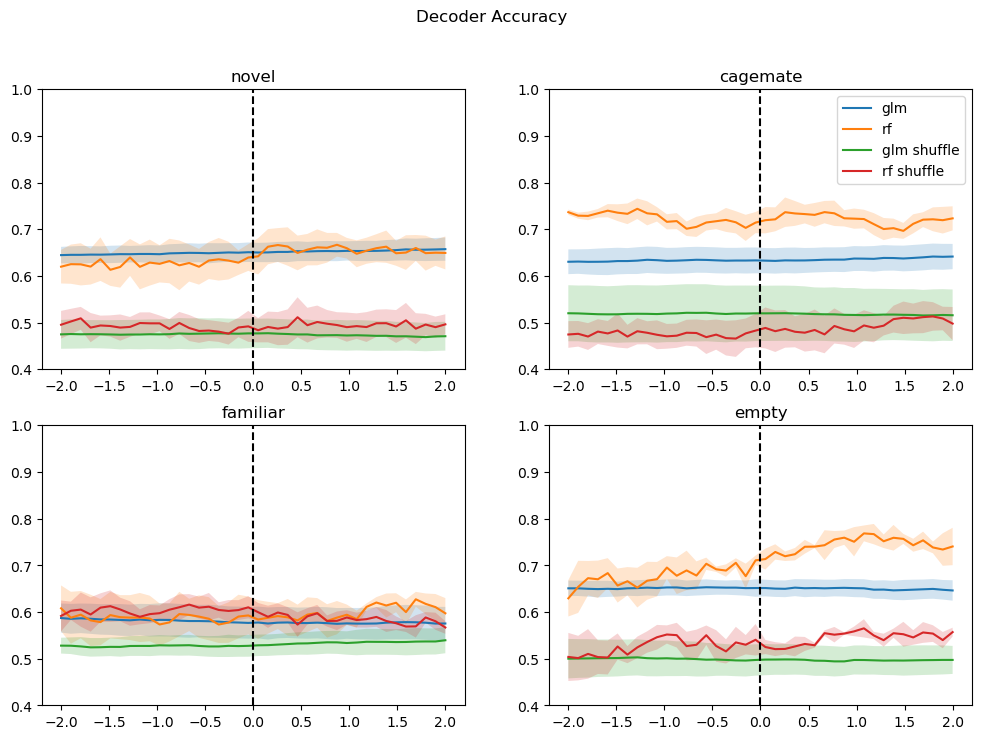

In [20]:
analysis_tester.__plot_auc__(auc, 2, 2)

In [21]:
#analysis_tester.wilcox_baseline_v_event_collection('novel', 3, 7, offset = -2)
analysis_tester.fishers_exact_wilcox('cagemate', 'familiar', 3, baseline_window = 7, offset = -2)

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: 

(0.3635765943458251, 0.036108177322645874, [[7, 169], [18, 158]])

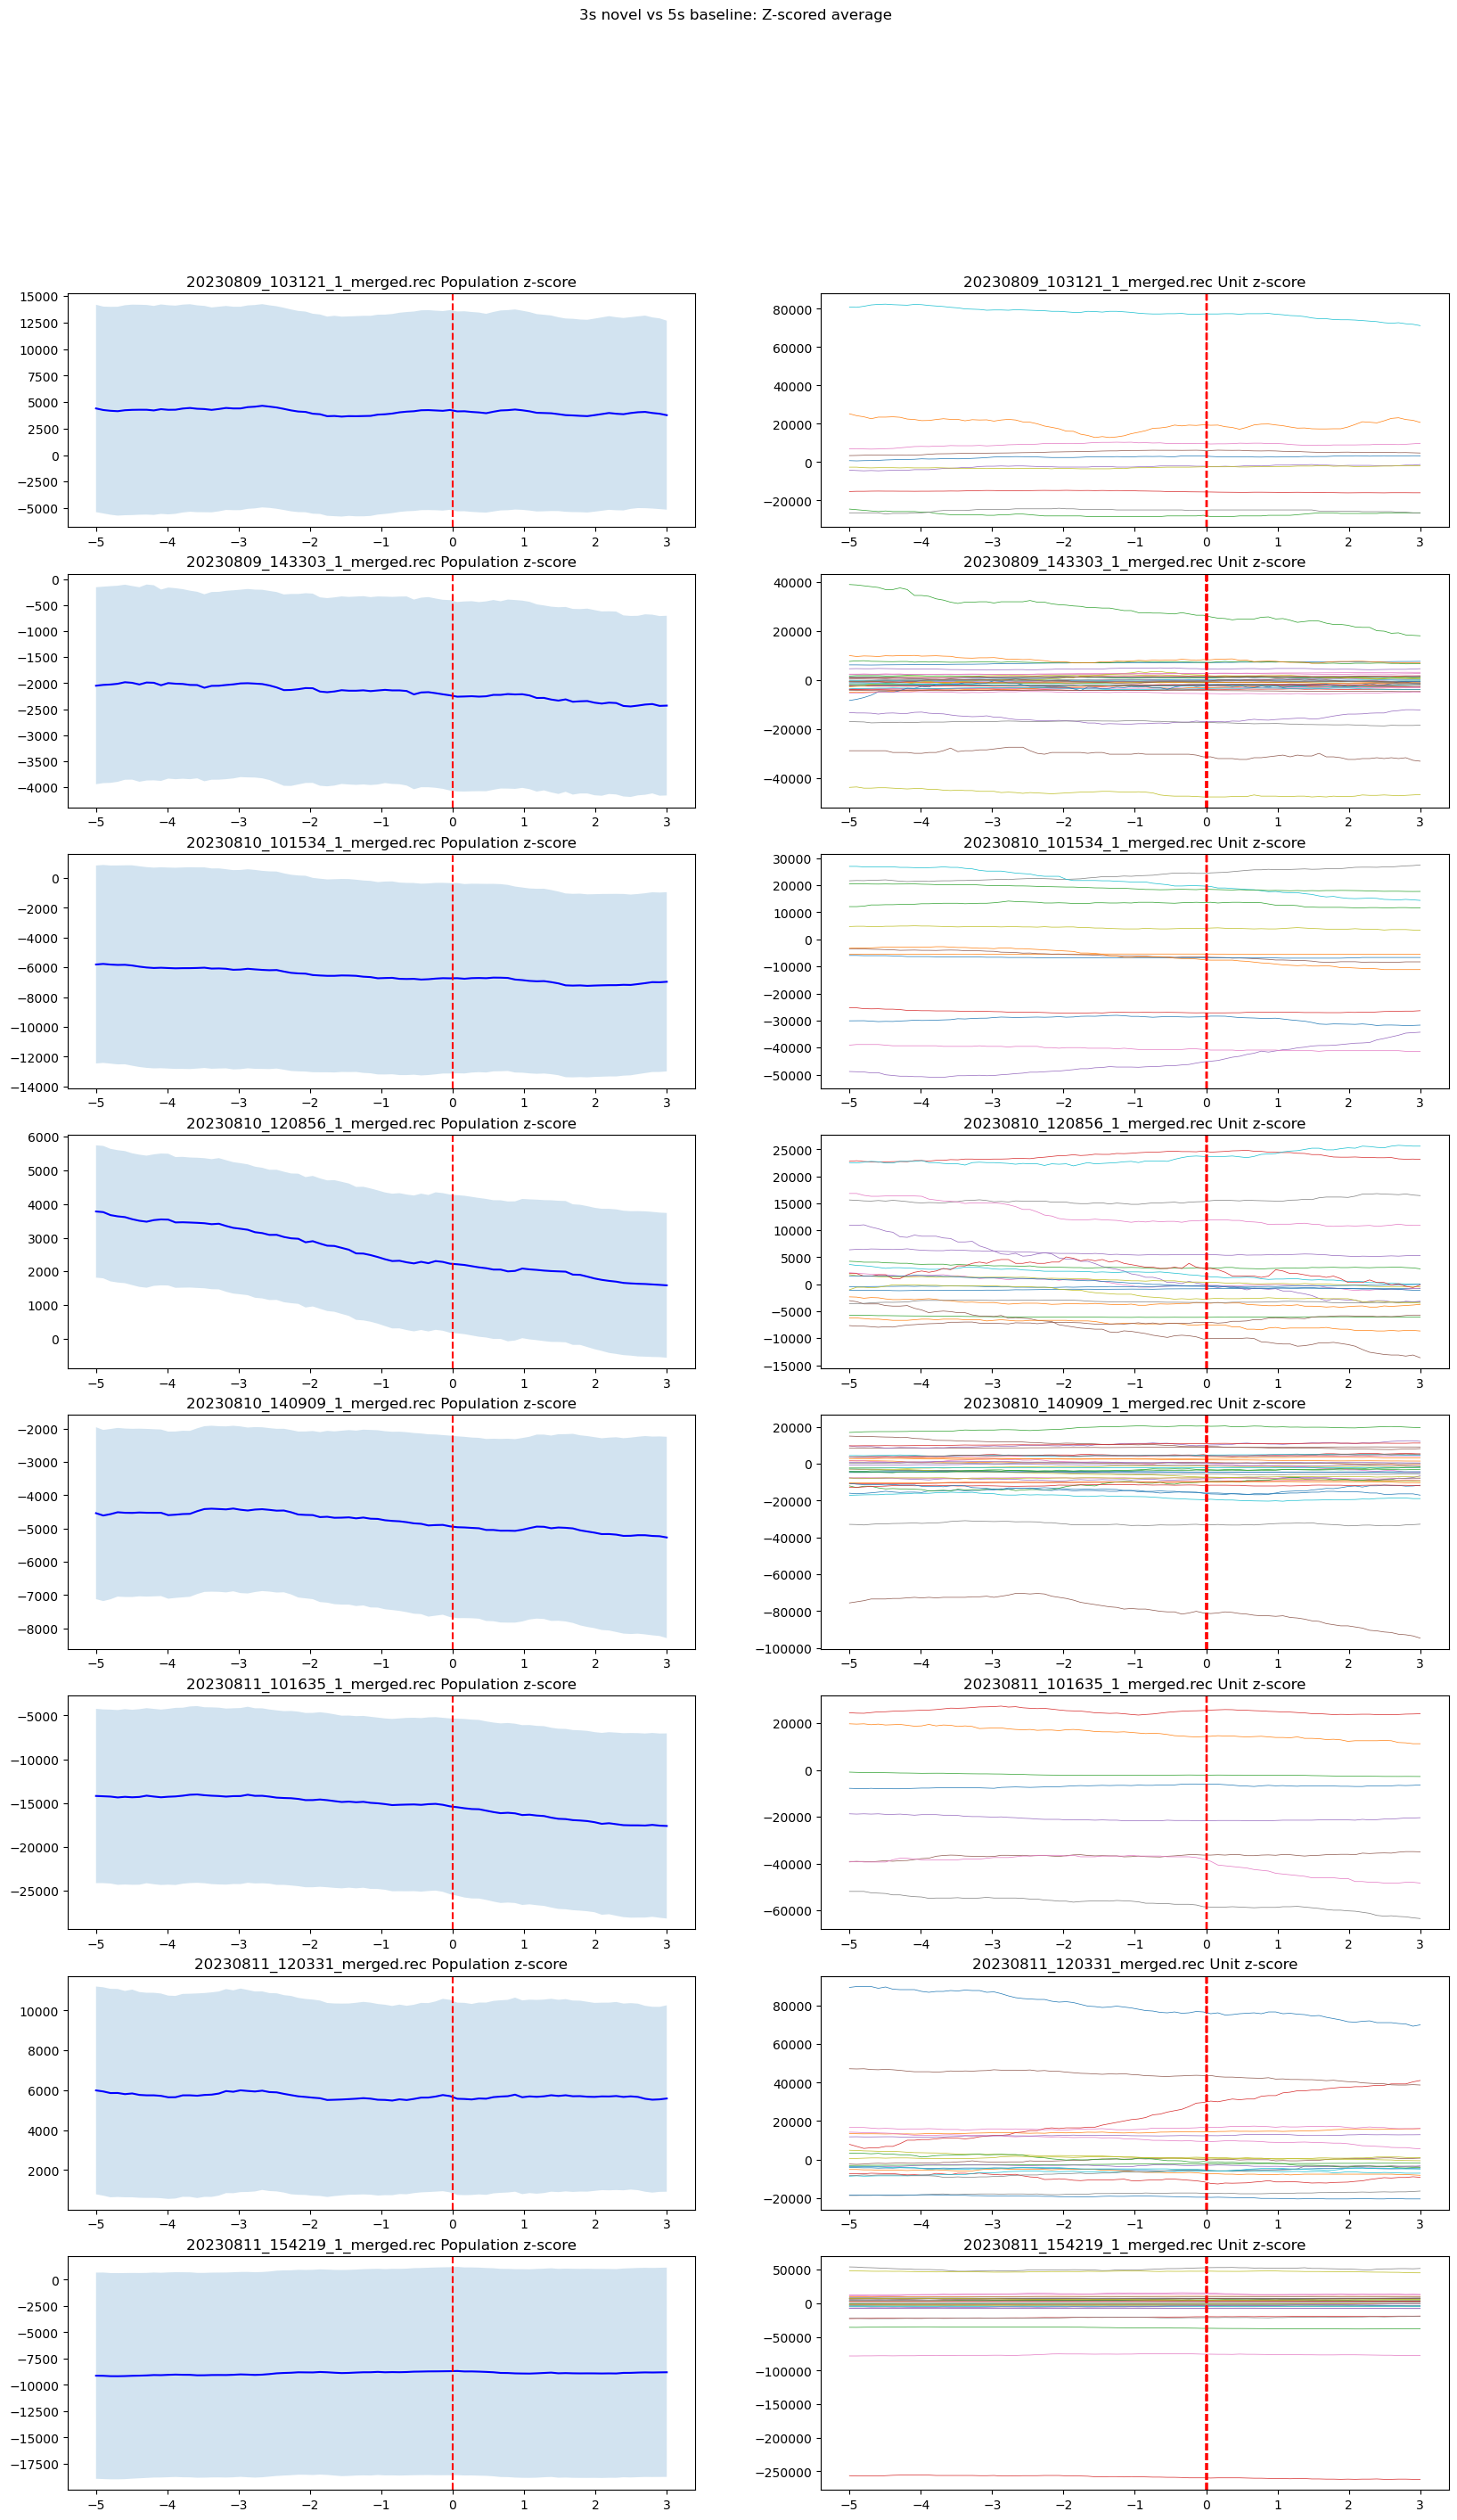

In [22]:
zscore_global_df = analysis_tester.zscore_global('novel', 3, 5, global_timebin= 1000, SD = 4)

In [23]:
#zscore_global_df[zscore_global_df['Significance'] != 'not significant'].count()
zscore_global_df[zscore_global_df['Significance'] == 'inhibitory'].count()[0]


0

In [24]:
zscore_global_df[zscore_global_df['Significance'] == 'excitatory'].count()[0]

75

In [25]:
zscore_global_df = analysis_tester.zscore_global('first fam', 3, 2, global_timebin= 60000, SD = 3, plot = False)
zscore_global_df[zscore_global_df['Significance'] == 'excitatory'].count()[0]

79

In [26]:
zscore_global_df[zscore_global_df['Significance'] == 'both?'].count()[0]

0

In [27]:
#analysis_tester.wilcox_event_v_event_collection('novel', 'empty', 10, 10, plot = True)
analysis_tester.fishers_exact_wilcox('cagemate', 'familiar', 5, event3= 'empty')

(0.7267080745341615, 0.4766336288754731, [[15, 161], [20, 156]])

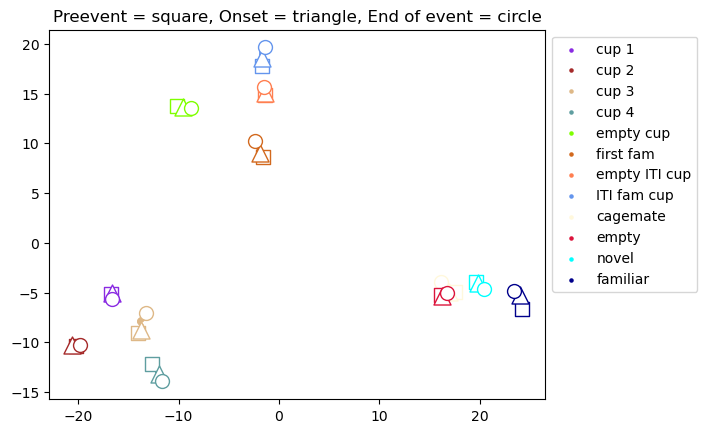

In [28]:
PCA_Df, PCA_components = analysis_tester.PCA_trajectories(3,2,plot=True)
#PCA_matrix = analysis_tester.PCA_matrix_generation(3, 2)

In [29]:
PCA_matrix.shape

NameError: name 'PCA_matrix' is not defined

In [ ]:
(172, 172)
(138, 138)
(169, 169)
(161, 161)
(146, 146)
(174, 174)
(161, 161)
(153, 153)
172
138
169
161
146
174
161
153

153

In [ ]:
matrix = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                   [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                   [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                   [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
                   [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
                   [26, 27, 28, 29, 30, 31 ,32, 33, 34, 35],
                   [31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
                   [36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
                   [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
                   [46, 47, 48, 49, 50, 51, 52, 53, 54, 55]])

matrix = np.delete(matrix, np.s_[2:5], axis=0)  # Remove rows 3-5
matrix = np.delete(matrix, np.s_[2:5], axis=1)  # Remove columns 3-5

# Print the resulting matrix
print(matrix)

[[ 1  2  6  7  8  9 10]
 [ 6  7 11 12 13 14 15]
 [26 27 31 32 33 34 35]
 [31 32 36 37 38 39 40]
 [36 37 41 42 43 44 45]
 [41 42 46 47 48 49 50]
 [46 47 51 52 53 54 55]]


In [ ]:
unit_total = 0
i = 0
for recording in phase3_collection.collection.values():
    unit_total = unit_total + len(recording.freq_dict.keys())
    for freq in recording.freq_dict.values():
        if freq <= 0.5:
            i+=1
print(unit_total, i, 211-29)
        

201 25 182


In [ ]:
analysis_tester.wilcox_baseline_v_event_collection('familiar', 5, 2, plot = False)

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: 

,original unit id,Wilcoxon Stat,p value,event1 vs event2,Recording,Subject,Event
0,293,3.0,0.465209,not significant,20230809_103121_1_merged.rec,1.1,2s familiar vs 5s baseline
1,80,4.0,0.715001,not significant,20230809_103121_1_merged.rec,1.1,2s familiar vs 5s baseline
2,252,3.0,1.000000,not significant,20230809_103121_1_merged.rec,1.1,2s familiar vs 5s baseline
3,211,0.0,0.067889,not significant,20230809_103121_1_merged.rec,1.1,2s familiar vs 5s baseline
4,276,2.0,0.273322,not significant,20230809_103121_1_merged.rec,1.1,2s familiar vs 5s baseline
...,...,...,...,...,...,...,...
171,76,16.0,0.779435,not significant,20230811_154219_1_merged.rec,1.4,2s familiar vs 5s baseline
172,149,13.0,0.483840,not significant,20230811_154219_1_merged.rec,1.4,2s familiar vs 5s baseline
173,135,5.0,0.068704,not significant,20230811_154219_1_merged.rec,1.4,2s familiar vs 5s baseline
174,38,9.0,0.207578,not significant,20230811_154219_1_merged.rec,1.4,2s familiar vs 5s baseline


c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


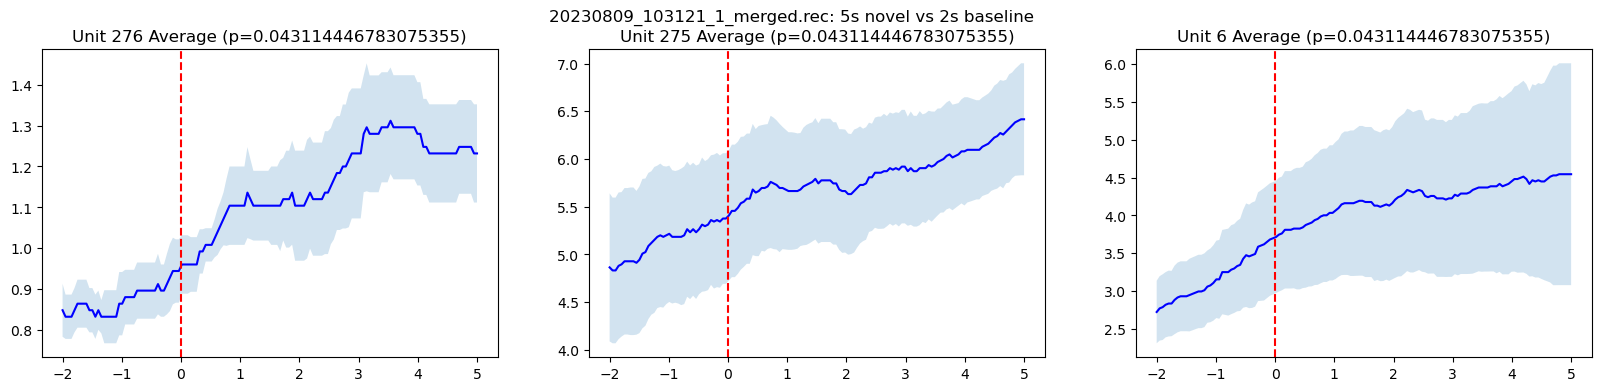

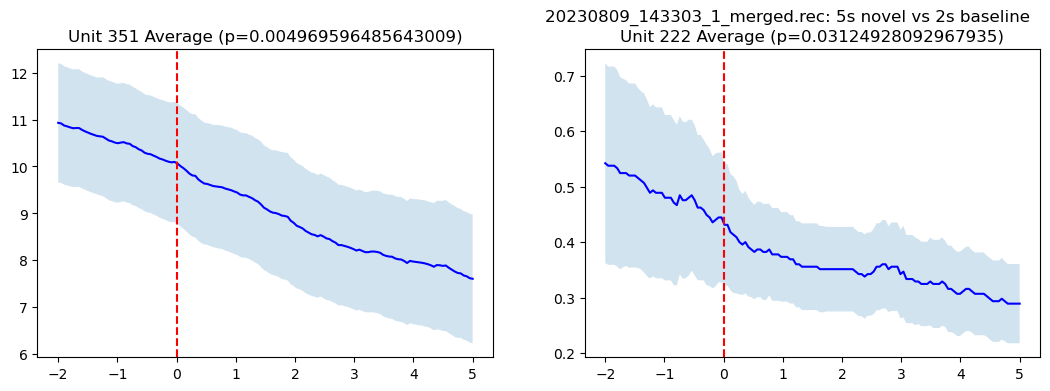

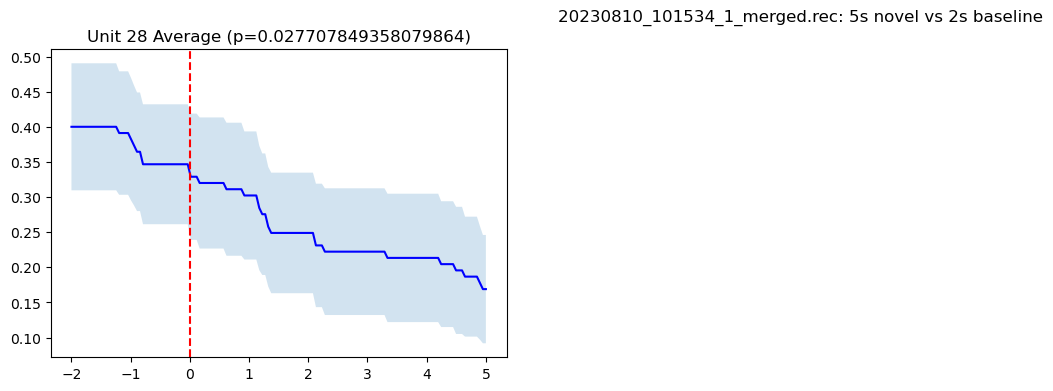

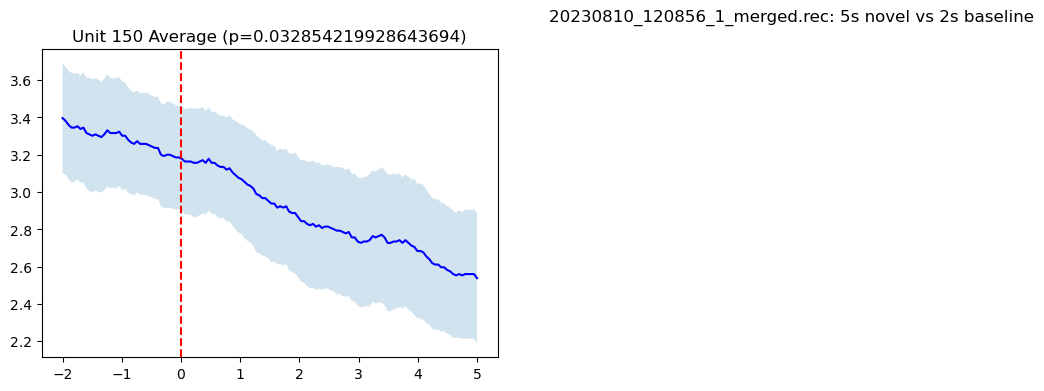

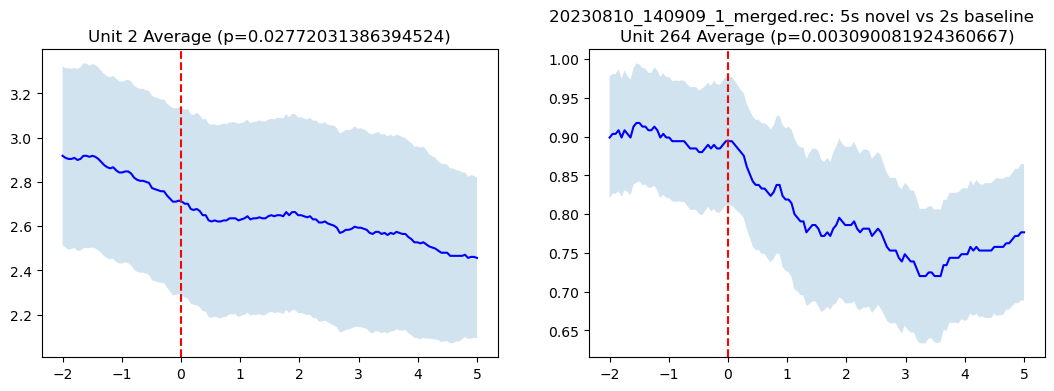

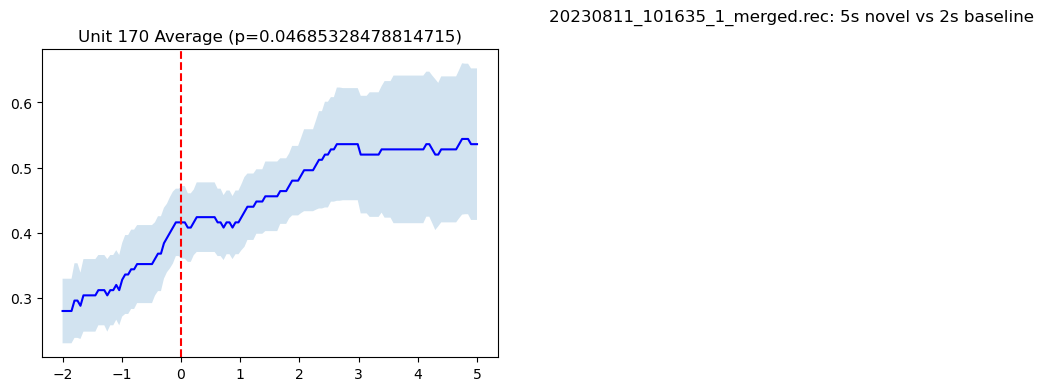

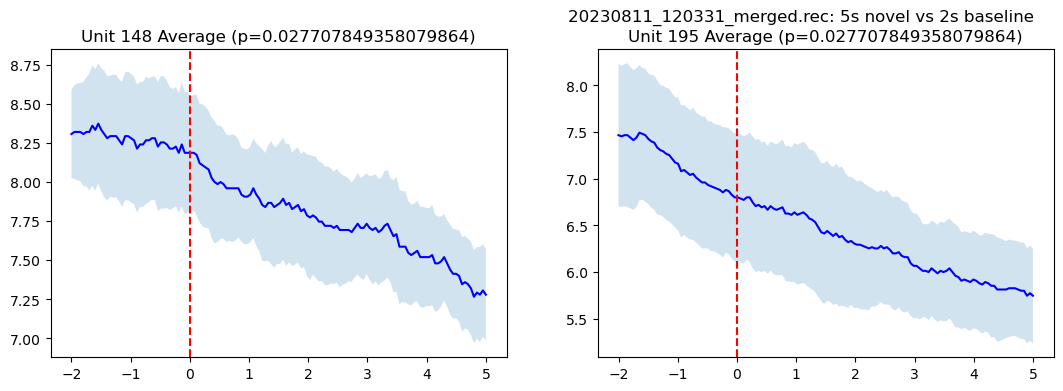

<Figure size 2000x0 with 0 Axes>

,original unit id,Wilcoxon Stat,p value,event1 vs event2,Recording,Subject,Event
0,293,4.0,0.345231,not significant,20230809_103121_1_merged.rec,1.1,5s novel vs 2s baseline
1,80,7.0,0.892738,not significant,20230809_103121_1_merged.rec,1.1,5s novel vs 2s baseline
2,252,3.0,0.465209,not significant,20230809_103121_1_merged.rec,1.1,5s novel vs 2s baseline
3,211,5.0,0.500184,not significant,20230809_103121_1_merged.rec,1.1,5s novel vs 2s baseline
4,276,0.0,0.043114,decreases,20230809_103121_1_merged.rec,1.1,5s novel vs 2s baseline
...,...,...,...,...,...,...,...
171,76,113.0,0.447031,not significant,20230811_154219_1_merged.rec,1.4,5s novel vs 2s baseline
172,149,83.0,0.094362,not significant,20230811_154219_1_merged.rec,1.4,5s novel vs 2s baseline
173,135,94.0,0.180812,not significant,20230811_154219_1_merged.rec,1.4,5s novel vs 2s baseline
174,38,85.0,0.177876,not significant,20230811_154219_1_merged.rec,1.4,5s novel vs 2s baseline


In [ ]:
analysis_tester.wilcox_baseline_v_event_collection('novel',2,5, save = True)


In [ ]:
analysis_tester.wilcox_event_v_event_collection('novel','cagemate',5, 2, plot = False, save=True)



,original unit id,Wilcoxon Stat,p value,event1 vs event2,Recording,Subject,Event
0,293,0.746360,0.455450,not significant,20230809_103121_1_merged.rec,1.1,novel vs cagemate (5s)
1,80,-0.817441,0.413676,not significant,20230809_103121_1_merged.rec,1.1,novel vs cagemate (5s)
2,252,-0.746360,0.455450,not significant,20230809_103121_1_merged.rec,1.1,novel vs cagemate (5s)
3,211,-0.817441,0.413676,not significant,20230809_103121_1_merged.rec,1.1,novel vs cagemate (5s)
4,276,0.319868,0.749068,not significant,20230809_103121_1_merged.rec,1.1,novel vs cagemate (5s)
...,...,...,...,...,...,...,...
171,76,0.767460,0.442808,not significant,20230811_154219_1_merged.rec,1.4,novel vs cagemate (5s)
172,149,0.632026,0.527370,not significant,20230811_154219_1_merged.rec,1.4,novel vs cagemate (5s)
173,135,1.489775,0.136283,not significant,20230811_154219_1_merged.rec,1.4,novel vs cagemate (5s)
174,38,-0.812605,0.416445,not significant,20230811_154219_1_merged.rec,1.4,novel vs cagemate (5s)


In [ ]:
analysis_tester.wilcox_baseline_v_event_collection('familiar',2,5, plot = False, save=True)
analysis_tester.wilcox_baseline_v_event_collection('cagemate', 2, 5,  plot = False, save = True)
phase3_collection.wilcox_dfs.keys()


c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: 

dict_keys(['5s novel vs 2s baseline', 'novel vs cagemate (5s)', '5s familiar vs 2s baseline', '5s cagemate vs 2s baseline'])

In [ ]:

analysis_tester.fishers_exact_wilcox('novel', 'cagemate', equalize = 5, baseline_window = 5, save = True)

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: 

(2.502439024390244, 0.13371189823385773, [[12, 164], [5, 171]])

In [ ]:
analysis_tester.export()

No PCA matrices have been saved
No z-scored events saved.


C:\Users\megha\AppData\Local\Temp\ipykernel_9564\657156927.py:1135: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Wilcoxon Stat_x', 'p value_x', 'event1 vs event2_x', 'Event_x'} in the result is deprecated and will raise a MergeError in a future version.
  master_df = master_df.merge(temp_df,


In [ ]:
analysis_tester.export()

No PCA matrices have been saved


In [ ]:
analysis_tester.wilcox_event_v_event_collection('cup 1', 'cup 2', 5, 2, False, save = True)

In [ ]:
analysis_tester.export()

No PCA matrices have been saved


In [ ]:
np.linspace(start=-2, stop=5, num=70)


array([-2.        , -1.89855072, -1.79710145, -1.69565217, -1.5942029 ,
       -1.49275362, -1.39130435, -1.28985507, -1.1884058 , -1.08695652,
       -0.98550725, -0.88405797, -0.7826087 , -0.68115942, -0.57971014,
       -0.47826087, -0.37681159, -0.27536232, -0.17391304, -0.07246377,
        0.02898551,  0.13043478,  0.23188406,  0.33333333,  0.43478261,
        0.53623188,  0.63768116,  0.73913043,  0.84057971,  0.94202899,
        1.04347826,  1.14492754,  1.24637681,  1.34782609,  1.44927536,
        1.55072464,  1.65217391,  1.75362319,  1.85507246,  1.95652174,
        2.05797101,  2.15942029,  2.26086957,  2.36231884,  2.46376812,
        2.56521739,  2.66666667,  2.76811594,  2.86956522,  2.97101449,
        3.07246377,  3.17391304,  3.27536232,  3.37681159,  3.47826087,
        3.57971014,  3.68115942,  3.7826087 ,  3.88405797,  3.98550725,
        4.08695652,  4.1884058 ,  4.28985507,  4.39130435,  4.49275362,
        4.5942029 ,  4.69565217,  4.79710145,  4.89855072,  5.  

array1:
[[1 2 3]
 [4 5 6]
 [7 8 9]]
array2:
[[11 12 13]
 [14 15 16]
 [17 18 19]]
